# Assignment 3: LSTM and GRU vs. Multiplicative Variations

### Maxim Ryabinov (U02204083)
### CAP4641: Natural Language Processing 
### Instructor: Dr. Ankur Mali 
### University of South Florida (Spring 2025)

---

# Description

In this assignment, I implemented Standard LSTM RNN, Standard GRU RNN, Multiplicative LSTM RNN, and Multiplicative GRU RNN. My choice for the machine learning library used in this notebook is TensorFlow.

Below, you will find an implementation for each recurrent neural network architecture, all following a set of model equations that each of the architectures are based off of.

Lastly, in order to show robustness and highlight the differences in gating mechanisms between the architectures, the Copy Task is carried out. Each model is ran through this task using varying lengths of sequences that contain a randomly generated set of characters (sequences lengths: `{100, 200, 500, 1000}`).



---

# 1. Initial Setup

In [11]:
# Imports all the libraries needed.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set seeds for reproducibility
# seed = 123

# tf.random.set_seed(seed)
# np.random.seed(seed)

# 2. Defining each RNN Architecture

This section contains the definitions for each type of RNN implementation that will be used for the copy task.

The models are as followed:
1. Standard LSTM Model
2. Multiplicative LSTM Model
3. Standard GRU Model
4. Multiplicative GRU Model

### 1. Standard LSTM RNN Implementation

This model implements the classic Long Short-Term Memory (LSTM) cell `StandardLSTMCell`, and then uses it in the higher-level RNN structure `StandardLSTM`. The cell itself captures long-term dependencies in sequential data using the following to control the information:

- Input Gate
- Forget Gate
- Output Gate
- Cell Candidate

The `StandardLSTM` class unrolls the LSTM cell over the sequence length, extracting the input at time `t` and passing it into the LSTM cell. The hidden state is then projected into `out_t` output and the final result is returned along with the hidden state and cell candidate (this information is used during the copy test when sequences are being split).

In [12]:
# Standard LSTM cell.
class StandardLSTMCell(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # Input gate weights and bias
        self.W_i = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_i = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_i = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Forget gate weights and bias
        self.W_f = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_f = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_f = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Output gate weights and bias
        self.W_o = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_o = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_o = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Cell candidate weights and bias
        self.W_c = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_c = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_c = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)

    # Forward pass: x_t is the input at time step t, h_prev is the hidden state at time step t-1, and c_prev is the cell state at time step t-1.
    def call(self, x_t, h_prev, c_prev):
        # Defines the Standard LSTM cell equations.
        i_t = tf.sigmoid(tf.matmul(x_t, self.W_i) + tf.matmul(h_prev, self.U_i) + self.b_i)
        f_t = tf.sigmoid(tf.matmul(x_t, self.W_f) + tf.matmul(h_prev, self.U_f) + self.b_f)
        o_t = tf.sigmoid(tf.matmul(x_t, self.W_o) + tf.matmul(h_prev, self.U_o) + self.b_o)
        c_hat = tf.tanh(tf.matmul(x_t, self.W_c) + tf.matmul(h_prev, self.U_c) + self.b_c)
        
        c_t = f_t * c_prev + i_t * c_hat
        h_t = o_t * tf.tanh(c_t)
        
        return h_t, c_t

# Higher-level Standard LSTM RNN that unrolls over time.
class StandardLSTM(tf.keras.layers.Layer):
    # Initializes the Standard LSTM RNN.
    def __init__(self, input_size, hidden_size, epochs, batch_size, learning_rate, optimizer, loss_fn):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm_cell = StandardLSTMCell(input_size, hidden_size)
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        
        # Output projection weights and bias.
        self.W_out = self.add_weight(shape=(hidden_size, input_size), initializer="random_normal", trainable=True)
        self.b_out = self.add_weight(shape=(input_size,), initializer="zeros", trainable=True)

    # Performs forward pass at higher level.
    def call(self, X, initial_state = None):
        # X input is structured as [batch_size, seq_length, input_size].
        batch_size = tf.shape(X)[0]
        seq_length = tf.shape(X)[1]
        
        # Initializes hidden state and cell state depending on whether initial_state is provided (assists with the training process).
        if initial_state == None:
            h = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
            c = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
        else:
            h, c = initial_state

        outputs = []
        
        # Unrolls the LSTM over time.
        for t in range(seq_length):
            x_t = X[:, t, :]
            h, c = self.lstm_cell(x_t, h, c)
            out_t = tf.matmul(h, self.W_out) + self.b_out
            outputs.append(tf.expand_dims(out_t, axis=1))
        return tf.concat(outputs, axis=1), (h, c)  # Returns [batch_size, seq_length, input_size] and h, c (hidden and cell states).

### 2. Multiplicative LSTM RNN Implementation

This model introduces modifications to the original RNN structure of `StandardLSTM`, including a multiplicative extension by having an additional set of weights and bias for the multiplicative layer.

This creates a learnable memory vector `m_t` and is used to calculating `x_cap_t` and being substituted for `x_t`.   

- Input Gate
- Forget Gate
- Output Gate
- Cell Candidate
- Memory Vector

Similar to the `StandardLSTM`class, the `MultiplicativeLSTM` class unrolls the `MultiplicativeLSTMCell` over the sequence length. At each time step `t`, the input is passed through the cell, which updates the hidden state and cell state. The hidden state is then projected into the output `out_t`. This process is repeated for each time step, and the final sequence of outputs is returned along with the hidden state and cell candidate (this information is used during the copy test when sequences are being split).

In [13]:
# Multiplicative LSTM cell.
class MultiplicativeLSTMCell(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # Input gate weights and bias
        self.W_i = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_i = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_i = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Forget gate weights and bias
        self.W_f = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_f = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_f = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Output gate weights and bias
        self.W_o = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_o = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_o = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Cell candidate weights and bias
        self.W_c = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_c = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_c = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)

        # Multiplicative extension weights and bias
        self.W_m = self.add_weight(shape=(input_size, input_size), initializer="random_normal", trainable=True)
        self.U_m = self.add_weight(shape=(hidden_size, input_size), initializer="random_normal", trainable=True)
        self.b_m = self.add_weight(shape=(input_size,), initializer="zeros", trainable=True)

    # Forward pass: x_t is the input at time step t, h_prev is the hidden state at time step t-1, and c_prev is the cell state at time step t-1.
    def call(self, x_t, h_prev, c_prev):
        # Defines the Multiplicative LSTM cell equations.
        
        # Multiplicative Extension
        m_t = tf.matmul(x_t, self.W_m) + tf.matmul(h_prev, self.U_m) + self.b_m
        x_cap = m_t * x_t
        
        i_t = tf.sigmoid(tf.matmul(x_cap, self.W_i) + tf.matmul(h_prev, self.U_i) + self.b_i)
        f_t = tf.sigmoid(tf.matmul(x_cap, self.W_f) + tf.matmul(h_prev, self.U_f) + self.b_f)
        o_t = tf.sigmoid(tf.matmul(x_cap, self.W_o) + tf.matmul(h_prev, self.U_o) + self.b_o)
        c_hat = tf.tanh(tf.matmul(x_cap, self.W_c) + tf.matmul(h_prev, self.U_c) + self.b_c)
        
        c_t = f_t * c_prev + i_t * c_hat
        h_t = o_t * tf.tanh(c_t)
        
        return h_t, c_t

# Higher-level Multiplicative LSTM RNN that unrolls over time.
class MultiplicativeLSTM(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size, epochs, batch_size, learning_rate, optimizer, loss_fn):
        # Initializes the Multiplicative LSTM RNN.
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm_cell = MultiplicativeLSTMCell(input_size, hidden_size)
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        
        # Output projection weights and bias.
        self.W_out = self.add_weight(shape=(hidden_size, input_size), initializer="random_normal", trainable=True)
        self.b_out = self.add_weight(shape=(input_size,), initializer="zeros", trainable=True)

    # Performs forward pass at higher level.
    def call(self, X, initial_state=None):
        # X: [batch_size, seq_length, input_size].
        batch_size = tf.shape(X)[0]
        seq_length = tf.shape(X)[1]

        # Initializes hidden state and cell state depending on whether initial_state is provided.
        if initial_state == None:
            h = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
            c = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
        else:
            h, c = initial_state

        outputs = []
        
        # Unrolls the LSTM over time.
        for t in range(seq_length):
            x_t = X[:, t, :]
            h, c = self.lstm_cell(x_t, h, c)
            out_t = tf.matmul(h, self.W_out) + self.b_out
            outputs.append(tf.expand_dims(out_t, axis=1))
        return tf.concat(outputs, axis=1), (h, c)  # Returns [batch_size, seq_length, input_size] and h, c.

### 3. Standard GRU RNN Implementation

This model implements the Gated Recurrent Unit (GRU) cell `StandardGRUCell`, and then uses it in the higher-level RNN structure `StandardGRU`. The GRU cell is a simplified version of the LSTM cell, designed to capture long-term dependencies in sequential data. It controls the flow of information through the following components:

- Update Gate
- Reset Gate
- Candidate Hidden State

The `StandardGRU` class unrolls the GRU cell over the sequence length, extracting the input at time `t` and passing it into the GRU cell. The hidden state is then projected into the `out_t` output, and the final result is returned along with the hidden state (this information is used during the copy test when sequences are being split).

In [14]:
# Standard GRU cell.
class StandardGRUCell(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # Update gate weights and bias.
        self.W_z = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_z = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_z = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Reset gate weights and bias.
        self.W_r = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_r = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_r = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Candidate hidden state weights and bias.
        self.W_h = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_h = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_h = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)

    # Forward pass: x_t is the input at time step t, and h_prev is the hidden state at time step t-1.
    def call(self, x_t, h_prev):
        # Update gate
        z_t = tf.sigmoid(tf.matmul(x_t, self.W_z) + tf.matmul(h_prev, self.U_z) + self.b_z)
        
        # Reset gate
        r_t = tf.sigmoid(tf.matmul(x_t, self.W_r) + tf.matmul(h_prev, self.U_r) + self.b_r)
        
        # Candidate hidden state
        h_hat = tf.tanh(tf.matmul(x_t, self.W_h) + tf.matmul(r_t * h_prev, self.U_h) + self.b_h)
        
        # New hidden state
        h_t = (1 - z_t) * h_prev + z_t * h_hat
        
        return h_t

# Higher-level Standard GRU RNN that unrolls over time.
class StandardGRU(tf.keras.layers.Layer):
    # Initializes the Standard GRU RNN.
    def __init__(self, input_size, hidden_size, epochs, batch_size, learning_rate, optimizer, loss_fn):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gru_cell = StandardGRUCell(input_size, hidden_size)
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.loss_fn = loss_fn

        # Output projection weights and bias.
        self.W_out = self.add_weight(shape=(hidden_size, input_size), initializer="random_normal", trainable=True)
        self.b_out = self.add_weight(shape=(input_size,), initializer="zeros", trainable=True)

    # Performs forward pass at higher level.
    def call(self, X, initial_state=None):
        # X: [batch_size, seq_length, input_size]
        batch_size = tf.shape(X)[0]
        seq_length = tf.shape(X)[1]
        
        # Initializes hidden state depending on whether initial_state is provided.
        if initial_state == None:
            h = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
        else:
            h = initial_state

        outputs = []
        
        # Unrolls the GRU over time.
        for t in range(seq_length):
            x_t = X[:, t, :]
            h = self.gru_cell(x_t, h)
            out_t = tf.matmul(h, self.W_out) + self.b_out
            outputs.append(tf.expand_dims(out_t, axis=1))
        return tf.concat(outputs, axis=1), h  # Returns [batch_size, seq_length, input_size] and h.

### 4. Multiplicative GRU RNN Implementation

This model implements the Multiplicative Gated Recurrent Unit (GRU) cell `MultiplicativeGRUCell`, and then uses it in the higher-level RNN structure `MultiplicativeGRU`. The Multiplicative GRU introduces a multiplicative extension to the original GRU cell. It is used to capture long-term dependencies in sequential data using the following components:

- Update Gate
- Reset Gate
- Candidate Hidden State
- Memory Vector

The `MultiplicativeGRU` class unrolls the GRU cell over the sequence length, extracting the input at `time t` and passing it into the GRU cell. The hidden state is then projected into the `out_t` output, and the final result is returned along with the hidden state (this information is used during the copy test when sequences are being split).


In [15]:
# Multiplicative GRU cell.
class MultiplicativeGRUCell(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # Update gate weights
        self.W_z = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_z = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_z = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Reset gate weights
        self.W_r = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_r = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_r = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Candidate hidden state weights
        self.W_h = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_h = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_h = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)

        # Multiplicative extension weights and bias
        self.W_m = self.add_weight(shape=(input_size, input_size), initializer="random_normal", trainable=True)
        self.U_m = self.add_weight(shape=(hidden_size, input_size), initializer="random_normal", trainable=True)
        self.b_m = self.add_weight(shape=(input_size,), initializer="zeros", trainable=True)

    # Forward pass: x_t is the input at time step t, and h_prev is the hidden state at time step t-1.
    def call(self, x_t, h_prev):
        # Memory matrix introduction
        m_t = tf.matmul(x_t, self.W_m) + tf.matmul(h_prev, self.U_m) + self.b_m
        x_cap = m_t * x_t

        # Update gate
        z_t = tf.sigmoid(tf.matmul(x_cap, self.W_z) + tf.matmul(h_prev, self.U_z) + self.b_z)
        
        # Reset gate
        r_t = tf.sigmoid(tf.matmul(x_cap, self.W_r) + tf.matmul(h_prev, self.U_r) + self.b_r)
        
        # Candidate hidden state
        h_hat = tf.tanh(tf.matmul(x_cap, self.W_h) + tf.matmul(r_t * h_prev, self.U_h) + self.b_h)
        
        # New hidden state
        h_t = (1 - z_t) * h_prev + z_t * h_hat
        
        return h_t

# Higher-level Multiplicative GRU RNN that unrolls over time.
class MultiplicativeGRU(tf.keras.layers.Layer):
    # Initializes the Multiplicative GRU RNN.
    def __init__(self, input_size, hidden_size, epochs, batch_size, learning_rate, optimizer, loss_fn):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gru_cell = MultiplicativeGRUCell(input_size, hidden_size)
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        
        # Output projection weights and bias.
        self.W_out = self.add_weight(shape=(hidden_size, input_size), initializer="random_normal", trainable=True)
        self.b_out = self.add_weight(shape=(input_size,), initializer="zeros", trainable=True)

    # Performs forward pass at higher level.
    def call(self, X, initial_state=None):
        # X: [batch_size, seq_length, input_size]
        batch_size = tf.shape(X)[0]
        seq_length = tf.shape(X)[1]
        h = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
        
        # Initializes hidden state depending on whether initial_state is provided.
        if initial_state == None:
            h = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
        else:
            h = initial_state

        outputs = []
        
        # Unrolls the GRU over time.
        for t in range(seq_length):
            x_t = X[:, t, :]
            h = self.gru_cell(x_t, h)
            out_t = tf.matmul(h, self.W_out) + self.b_out
            outputs.append(tf.expand_dims(out_t, axis=1))
        return tf.concat(outputs, axis=1), h  # [batch_size, seq_length, input_size] and h

# 3. Running the Copy Task

### Train, Test, and Validation Splits

This function is in charge of generating the random sequences used for the copy task. In order for the copy task to work, it also adds a few delimiters at the end of the generated sequence.

The X and Y datasets generated represent the input sequences for the model and the target output sequences that the model should be able to regenerate through the RNN.

In [16]:
# Generates dataset splits.
def generate_dataset_splits(sequence_count, input_size, training_length, sequence_length, delimiter, total_delimiters):
    # Generates random sequences of integers between 0 and 9 (10 is used as the delimiter in my testing).
    X_train = np.random.randint(0, 10, size=(sequence_count, training_length-total_delimiters, input_size)).astype(np.float32)
    X_val = np.random.randint(0, 10, size=(sequence_count, training_length-total_delimiters, input_size)).astype(np.float32)
    X_test = np.random.randint(0, 10, size=(sequence_count, sequence_length-total_delimiters, input_size)).astype(np.float32)
    delimiters = np.full((sequence_count, total_delimiters, input_size), delimiter, dtype=np.float32)
    
    # Concatenates the delimiters to the end of the sequences.
    X_train = np.concatenate([X_train, delimiters], axis=1)
    X_val = np.concatenate([X_val, delimiters], axis=1)
    X_test = np.concatenate([X_test, delimiters], axis=1)
    
    # Copies the input sequences to be used as the target sequences
    Y_train = X_train.copy()
    Y_val = X_val.copy()
    Y_test = X_test.copy()
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

### Training and Validating the Model (Training Loop)

This function simply defines the training process for the model. It will train the model multiple times depending on the number of epochs (ten by default).

The function outputs relevant data to the training process:
- Current Epoch
- Training Loss
- Validation Loss
- Training Accuracy
- Validation Accuracy

This is also accompanied with a plot generated, showing the relationship between loss and accuracy over epochs for both the validation and training datasets.

In [17]:
# Trains the model and plots the training and validation loss and accuracy.
def train_model(model, X_train, Y_train, X_val, Y_val):
    # Convert numpy arrays to tensors
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    Y_train = tf.convert_to_tensor(Y_train, dtype=tf.float32)
    X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
    Y_val = tf.convert_to_tensor(Y_val, dtype=tf.float32)
    
    # Used for plotting the graphs (just stores data during training). 
    train_loss_data = []
    val_loss_data = []
    train_accuracy_data = []
    val_accuracy_data = []
    
    # Training loop.
    for epoch in range(model.epochs):
        # Shuffle training data at the start of each epoch.
        indices = tf.range(start=X_train.shape[0])
        indices = tf.random.shuffle(indices)
        X_train = tf.gather(X_train, indices)
        Y_train = tf.gather(Y_train, indices)
        
        # Variables used to calculate the loss during each epoch.
        epoch_loss = 0
        num_batches = int(np.ceil(X_train.shape[0] / model.batch_size))

        # Loops through each batch.
        for i in range(num_batches):
            # Slices the data into batches.
            start = i * model.batch_size
            end = min((i+1) * model.batch_size, X_train.shape[0])
            X_batch = X_train[start:end]
            Y_batch = Y_train[start:end]
            
            # Converts the target sequences to labels (since I am using SparseCategoricalCrossentropy).
            Y_batch_labels = tf.argmax(Y_batch, axis=-1)
            
            # Forward pass and loss calculation.
            with tf.GradientTape() as tape:
                output, _ = model(X_batch)
                batch_loss = model.loss_fn(Y_batch_labels, output)
            gradients = tape.gradient(batch_loss, model.trainable_variables) # Calculate gradients.
            model.optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # Update weights for the model.
            
            epoch_loss += batch_loss.numpy()

        # Calculate average loss for the current epoch.
        epoch_loss /= num_batches
        
        # Calculates training accuracy.
        train_preds = np.argmax(output.numpy(), axis=-1).flatten()
        true_train = Y_batch_labels.numpy().flatten()
        train_accuracy = np.mean(train_preds == true_train)
        
        # Calculates validation loss and accuracy.
        val_output, _ = model(X_val)
        val_loss = model.loss_fn(tf.argmax(Y_val, axis=-1), val_output).numpy()
        val_preds = np.argmax(val_output.numpy(), axis=-1)
        true_val = tf.argmax(Y_val, axis=-1).numpy()
        val_accuracy = np.mean(val_preds == true_val)
        
        # Stores metrics for plotting later.
        train_loss_data.append(epoch_loss)
        val_loss_data.append(val_loss)
        train_accuracy_data.append(train_accuracy)
        val_accuracy_data.append(val_accuracy)
        
        print(f"Epoch {epoch+1:02d} | Training Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Training Accuracy: {train_accuracy:.4f} | Val Accuracy: {val_accuracy:.4f}")
        
    # After training loop, a plot for the training and validation loss and accuracy is generated.
    plt.figure(figsize=(10, 6))
    
    # Training data
    plt.plot(train_loss_data, label="Training Loss", marker=".", color="#1f77b4")
    plt.plot(train_accuracy_data, label="Training Accuracy", marker=".", color="#66c2ff")
    
    # Validation data
    plt.plot(val_loss_data, label="Validation Loss", marker=".", color="#d62728")
    plt.plot(val_accuracy_data, label="Validation Accuracy", marker=".", color="#ff7f7f")

    plt.xticks(range(len(train_loss_data))) # To display all epochs on x axis.

    # Defines the labels and title.
    plt.xlabel("Epoch")
    plt.ylabel("Loss and Accuracy")
    plt.title("Training and Validation Loss/Accuracy")
    plt.legend()
    plt.show()

### Evaluating the Model (Test Loop)

This function takes a trained model and evaluates its performance based the test sequences generated with varying lengths.

The function also outputs the following performance metrics:
- Segment Loss and Accuracy (if test sequence length is greater than training sequence length).
- Final Loss
- Final Accuracy

In [18]:
# Tests the model and prints the final test loss and accuracy.
def test_model(model, X_test, Y_test, sequence_length, training_length=100):
    # Convert numpy arrays to tensors.
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    Y_test = tf.convert_to_tensor(Y_test, dtype=tf.int32)
    
    # Variables used to calculate the loss during testing.
    test_loss = 0
    hidden_state = None # Used to keep the hidden state between segments (if test sequence length > train sequence length).
    num_test_segments = sequence_length // training_length

    all_test_preds = []  # Collect all predictions for final accuracy
    all_true_test = []   # Collect all true labels for final accuracy

    # Loops through each segment of the test data.
    for i in range(num_test_segments):
        # Determines the start and end slice of a segment.
        start = i * training_length
        end = start + training_length
        
        # Slices the data into segments.
        X_segment = X_test[:, start:end, :]
        Y_segment = tf.argmax(Y_test[:, start:end, :], axis=-1)

        # Checks if we are looking at the first segment or if we need to carry forward the hidden state.
        if hidden_state is None:
            output, hidden_state = model(X_segment) 
        else:
            output, hidden_state = model(X_segment, initial_state=hidden_state)

        # Calculates loss for the segment.
        segment_loss = model.loss_fn(Y_segment, output).numpy()
        test_loss += segment_loss

        # Calculates accuracy for the segment.
        test_preds = np.argmax(output.numpy(), axis=-1)
        true_test = Y_segment.numpy()

        # Collect for final accuracy calculation.
        all_test_preds.append(test_preds)
        all_true_test.append(true_test)
        
        # If multiple segments are present, this just prints out the loss and accuracy for each segment for additional analysis.
        if num_test_segments > 1:
            segment_accuracy = np.mean(test_preds == true_test)
            print(f"Segment {i + 1:02d}/{num_test_segments:02d} | Loss: {segment_loss:.4f} | Accuracy: {segment_accuracy:.4f}")

    # Calculates the average loss for all segments.
    test_loss /= num_test_segments

    # Combines all the predictions and labels for a final accuracy.
    all_test_preds = np.concatenate(all_test_preds, axis=1)
    all_true_test = np.concatenate(all_true_test, axis=1)
    test_accuracy = np.mean(all_test_preds == all_true_test)
    
    print(f"\nFinal Test Loss: {test_loss:.4f} | Final Test Accuracy: {test_accuracy:.4f}")
    
    return (test_loss, test_accuracy)
    

### Setting up the Copy Task Experiment

This function defines the overall copy task. It first defines the various settings as well as the hyper-parameters used across all models for a fair comparison. The function will then iterate through multiple trials (three in this case) across all sequence lengths, making sure to test each model. Finally, during the trial process, it outputs the following data for later analysis:

- Trial information
- Current model being trained
- Sequence length being tested
- Losses and accuracies during both training/validation and testing
- Graphs showing the relationships between the training and validation losses and accuracies.
- Final metric reports for all four models after a given sequence length has been tested
- A final report overview across all trials of the mean accuracy and loss as well as standard error for both metrics

In [19]:
# Runs a benchmark for the models.
def run_copytask_benchmark():
    # Constants used for the benchmark.
    vocabulary = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    delimiter = 10
    sequence_lengths = [100, 200, 500, 1000]
    sequence_count = 100 # Number of sequences to generate for training, validation, and testing (same across all models and sequence lengths testing for fair comparison).
    total_delimiters = 3 # Adds a few delimiters to make it clear that its the end of the sequence.
    
    # Hyper-parameters used across each model
    input_size = len(vocabulary) + 1 # Vocabulary tokens + delimiter token (just the number of unique tokens overall).
    hidden_size = 128 # Number of hidden units in the LSTM/GRU.
    training_length = 100 # Length of the training sequences.
    total_epochs = 10 # Number of epochs to train each model.
    batch_size = 32 # Batch size for training.
    learning_rate = 0.01 # Learning rate for the optimizer.
    
    # Storing and printing the training and testing status of each trial along with some analytical information.
    total_trials = 3
    
    # Creates a dictionary to store the metrics for each model. For each model, it stores a nested list that represents each sequence length,
    # where each of those lists contain tuples representing the average accuracy/loss pairs for that sequence length of that specific model.
    # 
    # The structure of this as follows:
    # {
    #     "Standard LSTM": [
    #         [(loss, accuracy), (loss, accuracy), ...],
    #         [(loss, accuracy), (loss, accuracy), ...],
    #         ...
    #     ],
    #     "Multiplicative LSTM": [
    #         [(loss, accuracy), (loss, accuracy), ...],
    #         ...
    #     ],
    #     "Standard GRU": [...],
    #     ...
    # }
    
    metrics = {"Standard LSTM": [], "Multiplicative LSTM": [], "Standard GRU": [], "Multiplicative GRU": []}
    
    for model_name, model_metrics in metrics.items():
        for sequence in sequence_lengths:
            metrics[model_name].append([])
    
    # Loops through each trial.
    for trial in range(total_trials):
        print(f"Running Trial {trial+1}/{total_trials} ================================================================================")
        # Loops through each sequence length.
        for i, sequence_length in enumerate(sequence_lengths):
            # Clears and redefines the models for each sequence length to prevent any carryover training from trials.
            models = {
                "Standard LSTM": StandardLSTM(input_size=input_size,
                                            hidden_size=hidden_size,
                                            epochs=total_epochs,
                                            batch_size=batch_size,
                                            learning_rate=learning_rate,
                                            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                            loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)),
                
                "Multiplicative LSTM": MultiplicativeLSTM(input_size=input_size,
                                            hidden_size=hidden_size,
                                            epochs=total_epochs,
                                            batch_size=batch_size,
                                            learning_rate=learning_rate,
                                            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                            loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)),
                
                "Standard GRU": StandardGRU(input_size=input_size,
                                            hidden_size=hidden_size,
                                            epochs=total_epochs,
                                            batch_size=batch_size,
                                            learning_rate=learning_rate,
                                            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                            loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)),
                
                "Multiplicative GRU": MultiplicativeGRU(input_size=input_size,
                                            hidden_size=hidden_size,
                                            epochs=total_epochs,
                                            batch_size=batch_size,
                                            learning_rate=learning_rate,
                                            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                            loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
            }
            
            # Loops through each model and trains and tests them on a given sequence length.
            for model_name, model in models.items():
                print(f"Training {model_name}:")
                # Generates the dataset splits for training, validation, and testing.
                X_train, X_val, X_test, Y_train, Y_val, Y_test = generate_dataset_splits(sequence_count,
                                                                                         input_size,
                                                                                         training_length,
                                                                                         sequence_length,
                                                                                         delimiter,
                                                                                         total_delimiters)
                # Trains the model and reports the training and validation loss and accuracy.
                train_model(model, X_train, Y_train, X_val, Y_val)
                
                # Tests the model and reports the final test loss and accuracy.
                print(f"\nTest Sequence Length: {sequence_length}")
                print(f'Testing {model_name}:')
                result_metrics = test_model(model, X_test, Y_test, sequence_length, training_length)
                metrics[model_name][i].append(result_metrics) # Stores (loss, accuracy) pair into metrics.
                print("-------------------------------------------------------------------------------------------------------")

            # Reports the final metrics for each model for a given sequence length being tested.
            print(f"*** Final metrics report for Trial {trial+1}/{total_trials} on sequence length of {sequence_length} ***")
            for model_name, model_metrics in metrics.items():
                print(model_name)
                print(f"Final Test Loss: {model_metrics[i][trial][0]:.4f}")
                print(f"Final Test Accuracy: {model_metrics[i][trial][1]:.4f}\n")

            print("=======================================================================================================")
            
    # Reports the mean performance (accuracy) and standard error of each model for each sequence across the total trials.
    print("\n===================================== Final Metrics Report =====================================\n")

    # Defines the format for the output.
    header_format = "{:<22} {:<22} {:<22} {:<22} {:<22} {:<22}"
    data_format = "{:<22} {:<22} {:<22.4f} {:<22.4f} {:<22.4f} {:<22.4f}"
    print(header_format.format("Model", "Sequence Length", "Mean Accuracy", "Std Error Accuracy", "Mean Loss", "Std Error Loss"))

    # Loops through the metrics stored for each model and reports mean accuracy and loss for each sequence length across the trials done.
    for model_name, model_metrics in metrics.items():
        for i, sequence_length in enumerate(sequence_lengths):
            accuracies = [trial[1] for trial in model_metrics[i]]  # Extract accuracy values
            losses = [trial[0] for trial in model_metrics[i]]  # Extract loss values
            
            # Calculates mean and standard error for accuracy and loss.
            mean_accuracy = np.mean(accuracies)
            mean_loss = np.mean(losses)
            std_error_accuracy = np.std(accuracies) / np.sqrt(len(accuracies))
            std_error_loss = np.std(losses) / np.sqrt(len(losses))

            # Prints the model and its corresponding metrics for each sequence length.
            print(data_format.format(model_name, sequence_length, mean_accuracy, std_error_accuracy, mean_loss, std_error_loss))

### Running Copy Task and Analyzing the Results

Run this cell when you are ready to run the copy task. As previously mentioned the output below will display data regarding the training and testing process across all the trials, as well as provide a report once the trials are concluded.

Here is the overall structure of the output:
- Current trial run
    - Current sequence being tested
        - Training loop (epochs, training loss/accuracy, validation loss/accuracy)
        - Graph plotting the relationship between loss/accuracy for training and validation across each epoch.
        - Test loop (sequence loss and accuracy if needed, final loss and accuracy)
    - Final summary report after all sequences have been tested.
- Final Performance Metric Report (mean loss and accuracy, standard error loss and accuracy)

Running Trial 1/3 ================================================================================
Training Standard LSTM:
Epoch 01 | Training Loss: 2.2730 | Val Loss: 2.0924 | Training Accuracy: 0.4075 | Val Accuracy: 0.4007
Epoch 02 | Training Loss: 1.9574 | Val Loss: 1.6911 | Training Accuracy: 0.4650 | Val Accuracy: 0.5639
Epoch 03 | Training Loss: 1.5325 | Val Loss: 1.3297 | Training Accuracy: 0.6325 | Val Accuracy: 0.6018
Epoch 04 | Training Loss: 1.1973 | Val Loss: 1.0471 | Training Accuracy: 0.6975 | Val Accuracy: 0.6919
Epoch 05 | Training Loss: 0.9504 | Val Loss: 0.8649 | Training Accuracy: 0.7775 | Val Accuracy: 0.7442
Epoch 06 | Training Loss: 0.7855 | Val Loss: 0.7605 | Training Accuracy: 0.8075 | Val Accuracy: 0.7798
Epoch 07 | Training Loss: 0.6778 | Val Loss: 0.6792 | Training Accuracy: 0.8275 | Val Accuracy: 0.8043
Epoch 08 | Training Loss: 0.6060 | Val Loss: 0.6409 | Training Accuracy: 0.8250 | Val Accuracy: 0.7767
Epoch 09 | Training Loss: 0.5537 | Val Loss: 0.5967 |

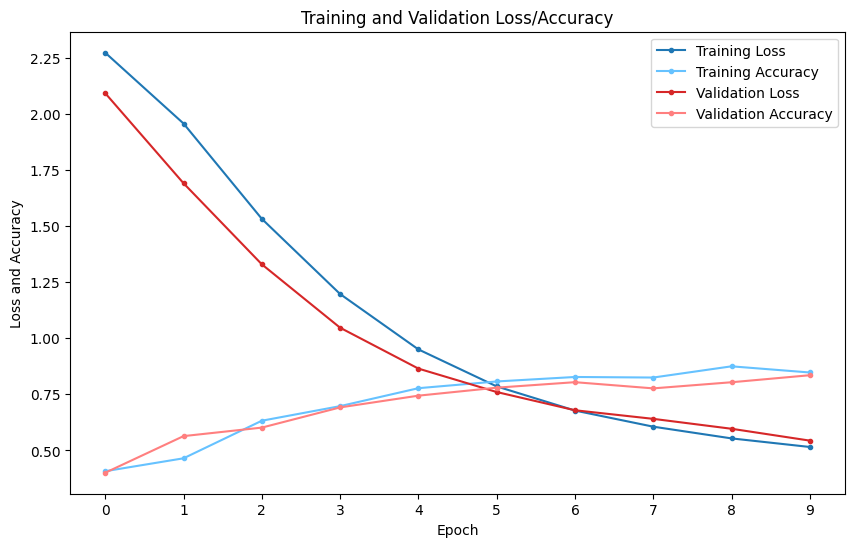


Test Sequence Length: 100
Testing Standard LSTM:

Final Test Loss: 0.5546 | Final Test Accuracy: 0.8292
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2662 | Val Loss: 2.0483 | Training Accuracy: 0.2800 | Val Accuracy: 0.3116
Epoch 02 | Training Loss: 1.9013 | Val Loss: 1.6677 | Training Accuracy: 0.4150 | Val Accuracy: 0.4630
Epoch 03 | Training Loss: 1.5147 | Val Loss: 1.3320 | Training Accuracy: 0.5575 | Val Accuracy: 0.5656
Epoch 04 | Training Loss: 1.2456 | Val Loss: 1.1158 | Training Accuracy: 0.5850 | Val Accuracy: 0.6243
Epoch 05 | Training Loss: 1.0172 | Val Loss: 0.9239 | Training Accuracy: 0.6850 | Val Accuracy: 0.6874
Epoch 06 | Training Loss: 0.8541 | Val Loss: 0.7985 | Training Accuracy: 0.7025 | Val Accuracy: 0.7208
Epoch 07 | Training Loss: 0.7241 | Val Loss: 0.7391 | Training Accuracy: 0.7475 | Val Accuracy: 0.7440
Epoch 08 | Training Loss: 0.6414 | Val L

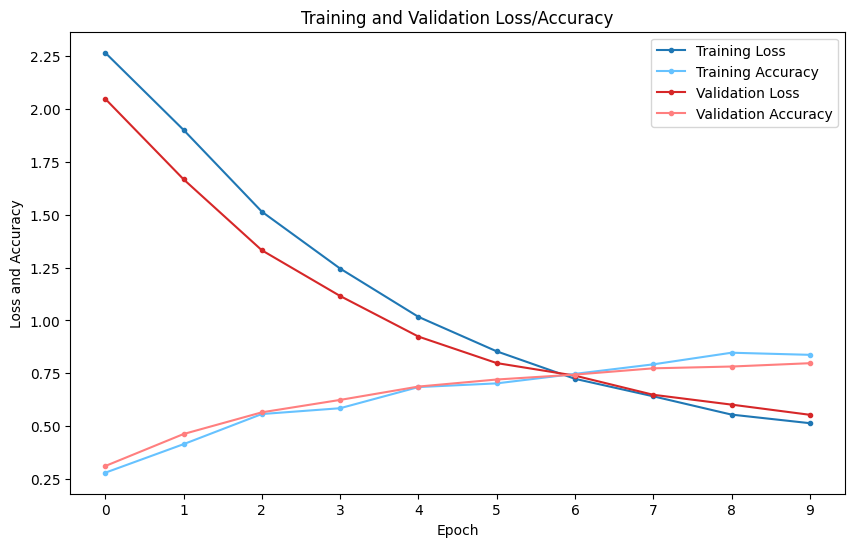


Test Sequence Length: 100
Testing Multiplicative LSTM:

Final Test Loss: 0.5645 | Final Test Accuracy: 0.7895
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.3265 | Val Loss: 2.0507 | Training Accuracy: 0.3225 | Val Accuracy: 0.2003
Epoch 02 | Training Loss: 1.8785 | Val Loss: 1.6502 | Training Accuracy: 0.4350 | Val Accuracy: 0.5024
Epoch 03 | Training Loss: 1.5085 | Val Loss: 1.3123 | Training Accuracy: 0.5950 | Val Accuracy: 0.6351
Epoch 04 | Training Loss: 1.1918 | Val Loss: 1.0564 | Training Accuracy: 0.7125 | Val Accuracy: 0.6604
Epoch 05 | Training Loss: 0.9614 | Val Loss: 0.8819 | Training Accuracy: 0.7950 | Val Accuracy: 0.7428
Epoch 06 | Training Loss: 0.8232 | Val Loss: 0.7422 | Training Accuracy: 0.7575 | Val Accuracy: 0.7979
Epoch 07 | Training Loss: 0.6962 | Val Loss: 0.6772 | Training Accuracy: 0.8400 | Val Accuracy: 0.8158
Epoch 08 | Training Loss: 0.6261 | Val Lo

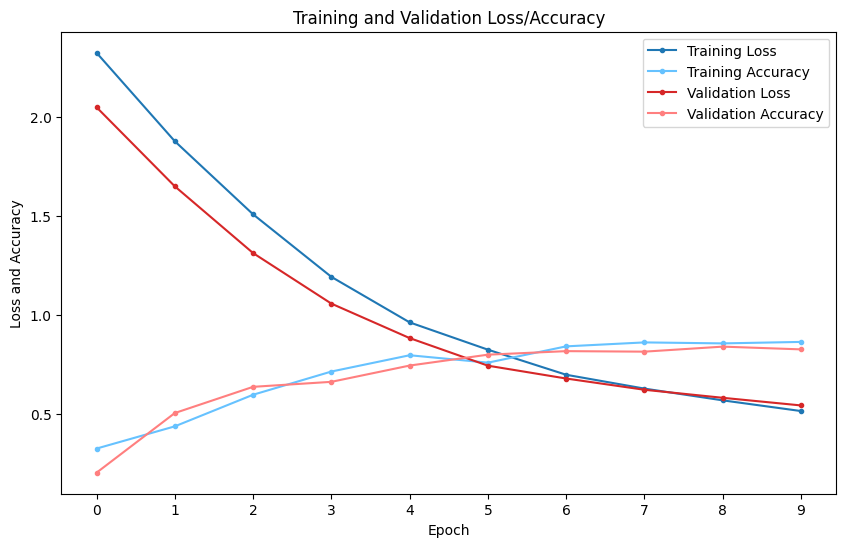


Test Sequence Length: 100
Testing Standard GRU:

Final Test Loss: 0.5428 | Final Test Accuracy: 0.8249
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.3209 | Val Loss: 2.1043 | Training Accuracy: 0.2200 | Val Accuracy: 0.3103
Epoch 02 | Training Loss: 1.9639 | Val Loss: 1.8267 | Training Accuracy: 0.4200 | Val Accuracy: 0.3822
Epoch 03 | Training Loss: 1.7136 | Val Loss: 1.5873 | Training Accuracy: 0.5125 | Val Accuracy: 0.4657
Epoch 04 | Training Loss: 1.4676 | Val Loss: 1.3395 | Training Accuracy: 0.5175 | Val Accuracy: 0.5470
Epoch 05 | Training Loss: 1.2478 | Val Loss: 1.1744 | Training Accuracy: 0.6000 | Val Accuracy: 0.5935
Epoch 06 | Training Loss: 1.0410 | Val Loss: 0.9749 | Training Accuracy: 0.6700 | Val Accuracy: 0.6575
Epoch 07 | Training Loss: 0.8588 | Val Loss: 0.8450 | Training Accuracy: 0.7175 | Val Accuracy: 0.7011
Epoch 08 | Training Loss: 0.7465 | Val Los

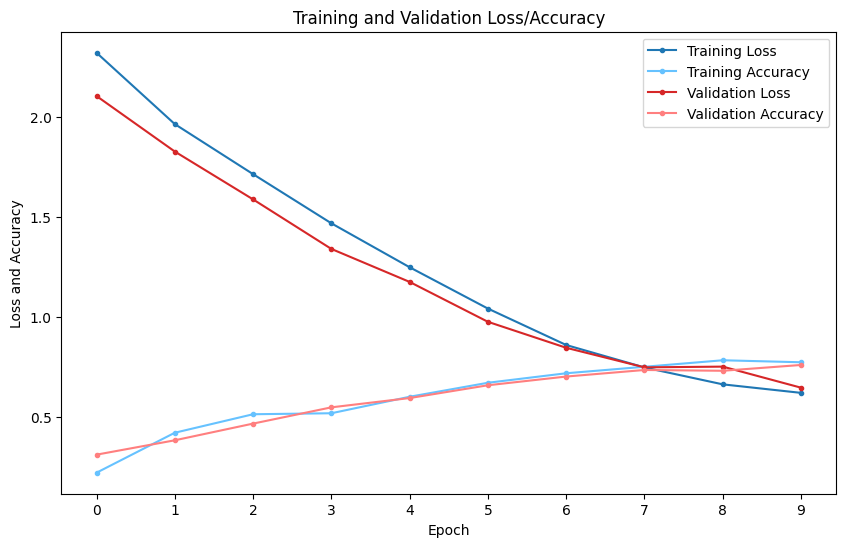


Test Sequence Length: 100
Testing Multiplicative GRU:

Final Test Loss: 0.6313 | Final Test Accuracy: 0.7685
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 1/3 on sequence length of 100 ***
Standard LSTM
Final Test Loss: 0.5546
Final Test Accuracy: 0.8292

Multiplicative LSTM
Final Test Loss: 0.5645
Final Test Accuracy: 0.7895

Standard GRU
Final Test Loss: 0.5428
Final Test Accuracy: 0.8249

Multiplicative GRU
Final Test Loss: 0.6313
Final Test Accuracy: 0.7685

Training Standard LSTM:
Epoch 01 | Training Loss: 2.2863 | Val Loss: 2.0957 | Training Accuracy: 0.2900 | Val Accuracy: 0.3497
Epoch 02 | Training Loss: 1.9697 | Val Loss: 1.7248 | Training Accuracy: 0.4850 | Val Accuracy: 0.5196
Epoch 03 | Training Loss: 1.5950 | Val Loss: 1.3501 | Training Accuracy: 0.5725 | Val Accuracy: 0.6477
Epoch 04 | Training Loss: 1.2497 | Val Loss: 1.1092 | Training Accuracy: 0.6575 | Val Accuracy: 0.6891
Epo

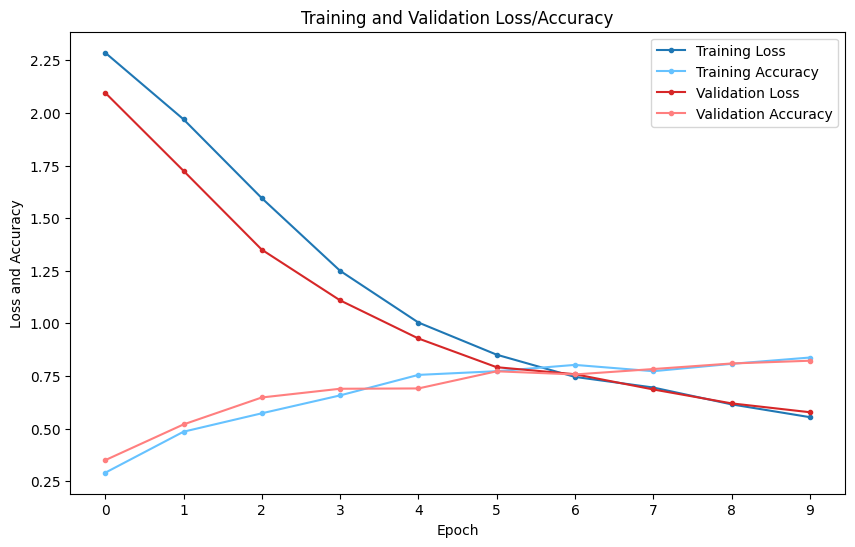


Test Sequence Length: 200
Testing Standard LSTM:
Segment 01/02 | Loss: 0.5913 | Accuracy: 0.8174
Segment 02/02 | Loss: 0.5808 | Accuracy: 0.8200

Final Test Loss: 0.5861 | Final Test Accuracy: 0.8187
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2971 | Val Loss: 2.1529 | Training Accuracy: 0.2625 | Val Accuracy: 0.3160
Epoch 02 | Training Loss: 2.0024 | Val Loss: 1.8057 | Training Accuracy: 0.3875 | Val Accuracy: 0.4110
Epoch 03 | Training Loss: 1.6538 | Val Loss: 1.4995 | Training Accuracy: 0.4875 | Val Accuracy: 0.5053
Epoch 04 | Training Loss: 1.3907 | Val Loss: 1.2956 | Training Accuracy: 0.5225 | Val Accuracy: 0.5646
Epoch 05 | Training Loss: 1.2065 | Val Loss: 1.1628 | Training Accuracy: 0.6075 | Val Accuracy: 0.6061
Epoch 06 | Training Loss: 1.0784 | Val Loss: 1.0569 | Training Accuracy: 0.6275 | Val Accuracy: 0.6395
Epoch 07 | Training Loss: 0.9600 | Val Loss: 0.

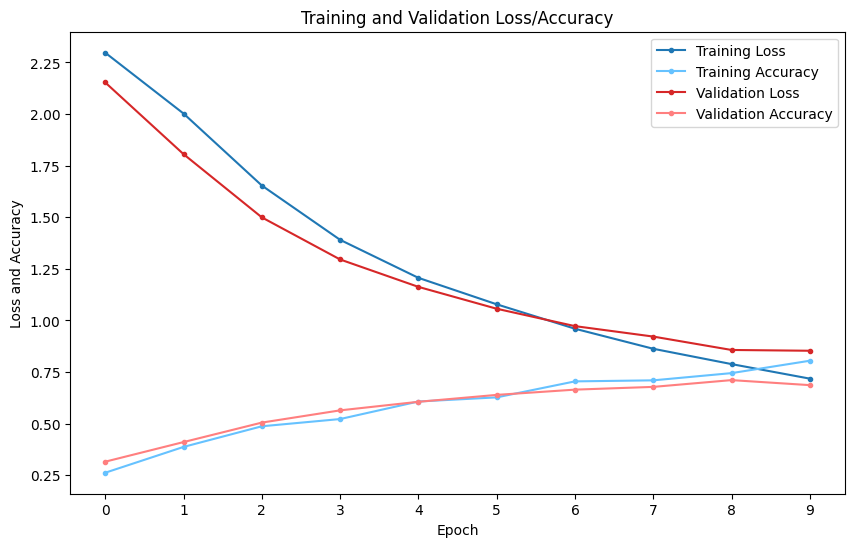


Test Sequence Length: 200
Testing Multiplicative LSTM:
Segment 01/02 | Loss: 0.8529 | Accuracy: 0.6841
Segment 02/02 | Loss: 0.8153 | Accuracy: 0.7015

Final Test Loss: 0.8341 | Final Test Accuracy: 0.6928
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.3701 | Val Loss: 2.0960 | Training Accuracy: 0.3250 | Val Accuracy: 0.4143
Epoch 02 | Training Loss: 1.9577 | Val Loss: 1.7180 | Training Accuracy: 0.4050 | Val Accuracy: 0.4890
Epoch 03 | Training Loss: 1.5812 | Val Loss: 1.3890 | Training Accuracy: 0.5750 | Val Accuracy: 0.6069
Epoch 04 | Training Loss: 1.2643 | Val Loss: 1.1381 | Training Accuracy: 0.6925 | Val Accuracy: 0.6468
Epoch 05 | Training Loss: 1.0342 | Val Loss: 0.9276 | Training Accuracy: 0.6950 | Val Accuracy: 0.7402
Epoch 06 | Training Loss: 0.8454 | Val Loss: 0.7884 | Training Accuracy: 0.7900 | Val Accuracy: 0.7794
Epoch 07 | Training Loss: 0.7272 | Val Loss: 0.6

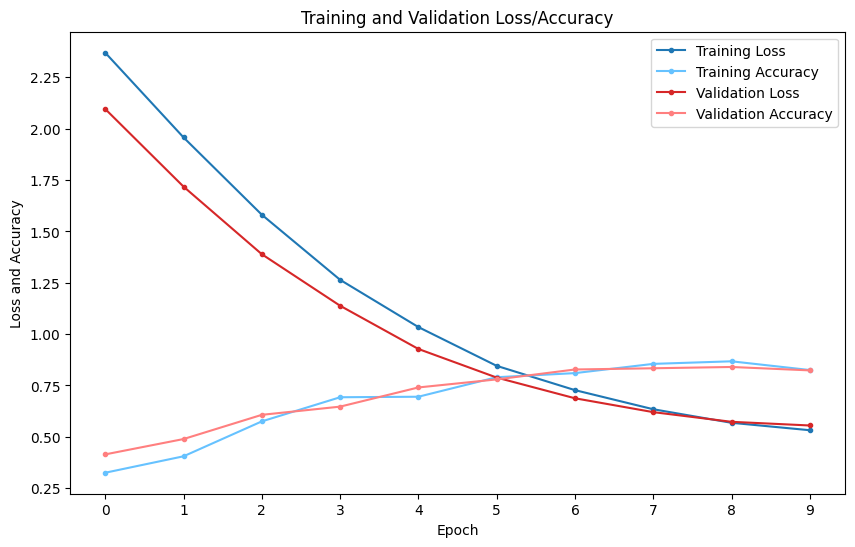


Test Sequence Length: 200
Testing Standard GRU:
Segment 01/02 | Loss: 0.5685 | Accuracy: 0.8252
Segment 02/02 | Loss: 0.5564 | Accuracy: 0.8199

Final Test Loss: 0.5625 | Final Test Accuracy: 0.8226
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.2365 | Val Loss: 1.9704 | Training Accuracy: 0.2925 | Val Accuracy: 0.3280
Epoch 02 | Training Loss: 1.8504 | Val Loss: 1.7345 | Training Accuracy: 0.4050 | Val Accuracy: 0.4204
Epoch 03 | Training Loss: 1.5816 | Val Loss: 1.4981 | Training Accuracy: 0.4850 | Val Accuracy: 0.4828
Epoch 04 | Training Loss: 1.3447 | Val Loss: 1.3290 | Training Accuracy: 0.5700 | Val Accuracy: 0.5407
Epoch 05 | Training Loss: 1.1812 | Val Loss: 1.2012 | Training Accuracy: 0.5875 | Val Accuracy: 0.5794
Epoch 06 | Training Loss: 1.0454 | Val Loss: 1.0943 | Training Accuracy: 0.6325 | Val Accuracy: 0.6189
Epoch 07 | Training Loss: 0.9464 | Val Loss: 1.04

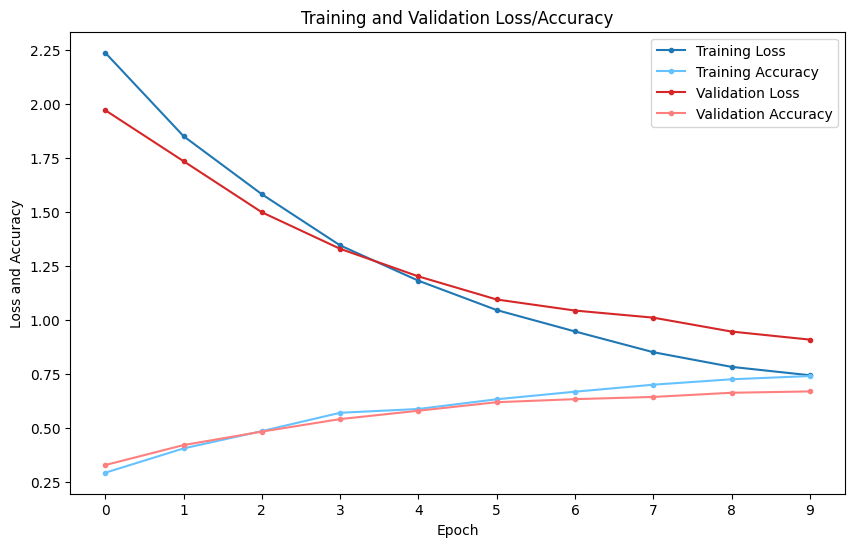


Test Sequence Length: 200
Testing Multiplicative GRU:
Segment 01/02 | Loss: 0.9391 | Accuracy: 0.6584
Segment 02/02 | Loss: 0.9284 | Accuracy: 0.6649

Final Test Loss: 0.9337 | Final Test Accuracy: 0.6616
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 1/3 on sequence length of 200 ***
Standard LSTM
Final Test Loss: 0.5861
Final Test Accuracy: 0.8187

Multiplicative LSTM
Final Test Loss: 0.8341
Final Test Accuracy: 0.6928

Standard GRU
Final Test Loss: 0.5625
Final Test Accuracy: 0.8226

Multiplicative GRU
Final Test Loss: 0.9337
Final Test Accuracy: 0.6616

Training Standard LSTM:
Epoch 01 | Training Loss: 2.2752 | Val Loss: 2.0814 | Training Accuracy: 0.3875 | Val Accuracy: 0.4144
Epoch 02 | Training Loss: 1.9339 | Val Loss: 1.6922 | Training Accuracy: 0.4375 | Val Accuracy: 0.5432
Epoch 03 | Training Loss: 1.5304 | Val Loss: 1.3288 | Training Accuracy: 0.6450 | Val Accuracy: 0.5634
Epoch 04 |

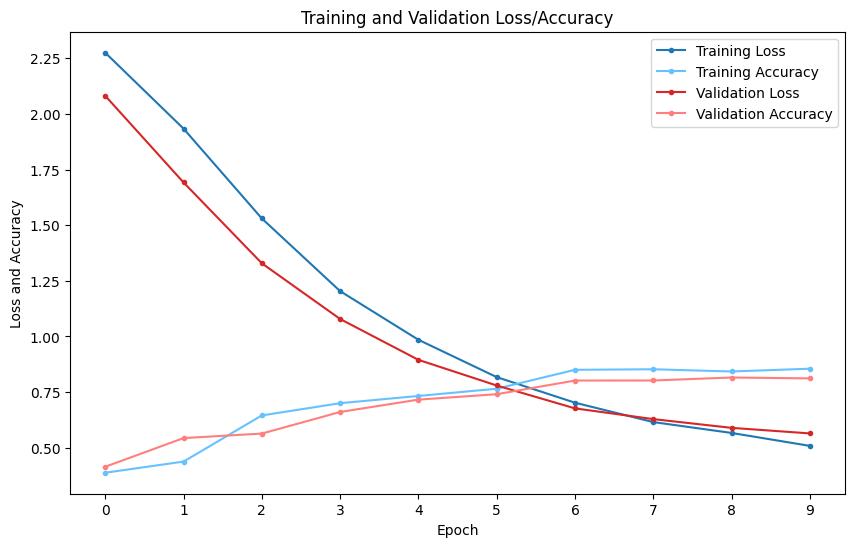


Test Sequence Length: 500
Testing Standard LSTM:
Segment 01/05 | Loss: 0.5878 | Accuracy: 0.8023
Segment 02/05 | Loss: 0.5744 | Accuracy: 0.8098
Segment 03/05 | Loss: 0.5805 | Accuracy: 0.8098
Segment 04/05 | Loss: 0.5697 | Accuracy: 0.8123
Segment 05/05 | Loss: 0.5563 | Accuracy: 0.8195

Final Test Loss: 0.5737 | Final Test Accuracy: 0.8107
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2695 | Val Loss: 2.0302 | Training Accuracy: 0.3150 | Val Accuracy: 0.3570
Epoch 02 | Training Loss: 1.8866 | Val Loss: 1.6083 | Training Accuracy: 0.4450 | Val Accuracy: 0.4899
Epoch 03 | Training Loss: 1.4816 | Val Loss: 1.2962 | Training Accuracy: 0.5525 | Val Accuracy: 0.5769
Epoch 04 | Training Loss: 1.2152 | Val Loss: 1.0913 | Training Accuracy: 0.6400 | Val Accuracy: 0.6348
Epoch 05 | Training Loss: 1.0066 | Val Loss: 0.9342 | Training Accuracy: 0.6950 | Val Accuracy: 0.6819
Epoch 

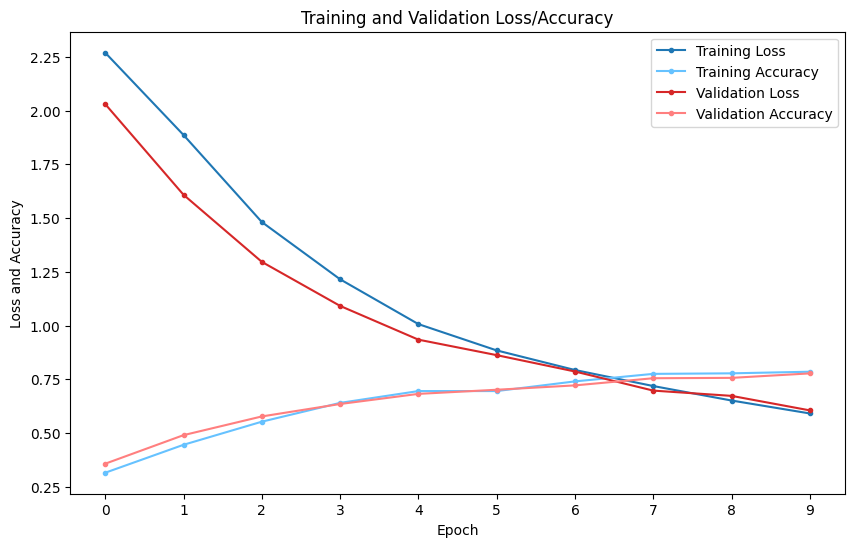


Test Sequence Length: 500
Testing Multiplicative LSTM:
Segment 01/05 | Loss: 0.6343 | Accuracy: 0.7647
Segment 02/05 | Loss: 0.6347 | Accuracy: 0.7662
Segment 03/05 | Loss: 0.6269 | Accuracy: 0.7732
Segment 04/05 | Loss: 0.6269 | Accuracy: 0.7699
Segment 05/05 | Loss: 0.5923 | Accuracy: 0.7826

Final Test Loss: 0.6230 | Final Test Accuracy: 0.7713
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.3067 | Val Loss: 2.0123 | Training Accuracy: 0.2850 | Val Accuracy: 0.4190
Epoch 02 | Training Loss: 1.8825 | Val Loss: 1.6288 | Training Accuracy: 0.3800 | Val Accuracy: 0.4998
Epoch 03 | Training Loss: 1.5160 | Val Loss: 1.3111 | Training Accuracy: 0.5375 | Val Accuracy: 0.6061
Epoch 04 | Training Loss: 1.2032 | Val Loss: 1.0694 | Training Accuracy: 0.6675 | Val Accuracy: 0.6700
Epoch 05 | Training Loss: 0.9753 | Val Loss: 0.8859 | Training Accuracy: 0.7550 | Val Accuracy: 0.7187
Epoch 0

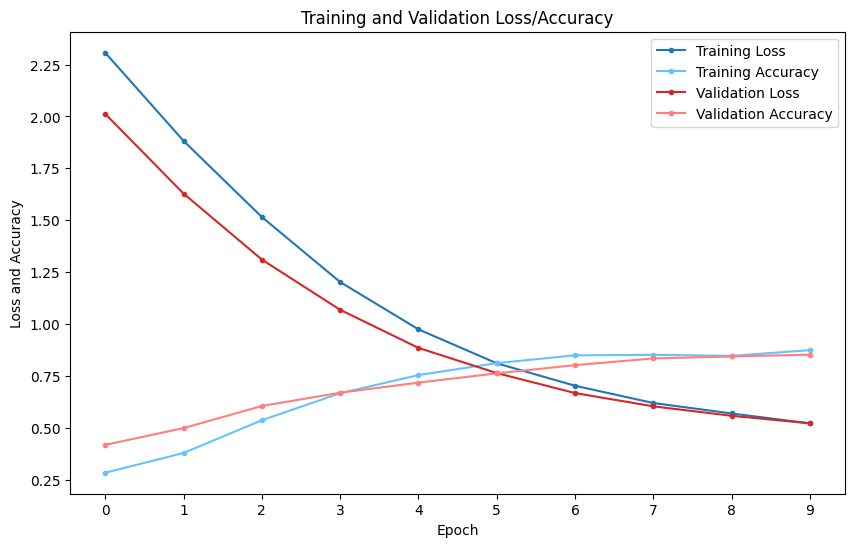


Test Sequence Length: 500
Testing Standard GRU:
Segment 01/05 | Loss: 0.5346 | Accuracy: 0.8519
Segment 02/05 | Loss: 0.5431 | Accuracy: 0.8488
Segment 03/05 | Loss: 0.5400 | Accuracy: 0.8530
Segment 04/05 | Loss: 0.5407 | Accuracy: 0.8477
Segment 05/05 | Loss: 0.5216 | Accuracy: 0.8542

Final Test Loss: 0.5360 | Final Test Accuracy: 0.8511
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.3186 | Val Loss: 2.1318 | Training Accuracy: 0.1875 | Val Accuracy: 0.2423
Epoch 02 | Training Loss: 2.0145 | Val Loss: 1.8221 | Training Accuracy: 0.3600 | Val Accuracy: 0.3899
Epoch 03 | Training Loss: 1.7071 | Val Loss: 1.5577 | Training Accuracy: 0.4400 | Val Accuracy: 0.4622
Epoch 04 | Training Loss: 1.4528 | Val Loss: 1.4593 | Training Accuracy: 0.4850 | Val Accuracy: 0.4797
Epoch 05 | Training Loss: 1.3059 | Val Loss: 1.2351 | Training Accuracy: 0.5800 | Val Accuracy: 0.5708
Epoch 06

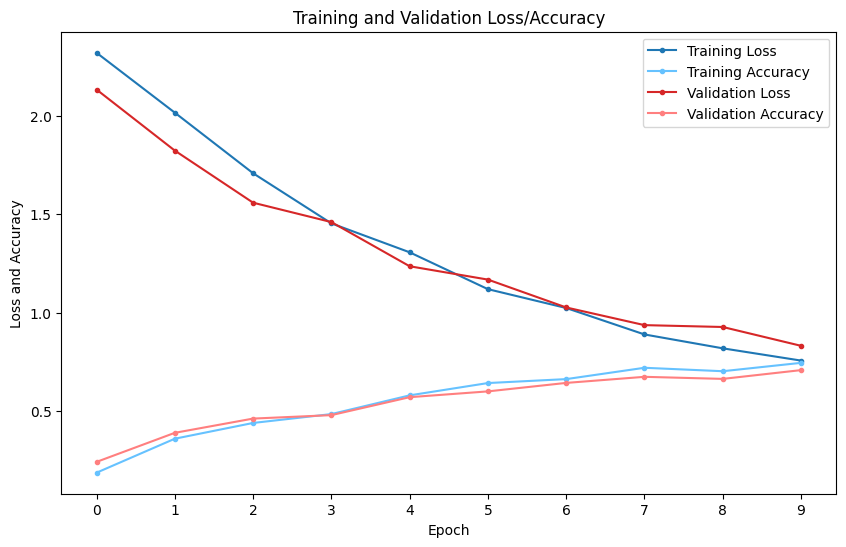


Test Sequence Length: 500
Testing Multiplicative GRU:
Segment 01/05 | Loss: 0.8672 | Accuracy: 0.6932
Segment 02/05 | Loss: 0.8573 | Accuracy: 0.6958
Segment 03/05 | Loss: 0.8363 | Accuracy: 0.6982
Segment 04/05 | Loss: 0.8502 | Accuracy: 0.6952
Segment 05/05 | Loss: 0.8146 | Accuracy: 0.7139

Final Test Loss: 0.8451 | Final Test Accuracy: 0.6993
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 1/3 on sequence length of 500 ***
Standard LSTM
Final Test Loss: 0.5737
Final Test Accuracy: 0.8107

Multiplicative LSTM
Final Test Loss: 0.6230
Final Test Accuracy: 0.7713

Standard GRU
Final Test Loss: 0.5360
Final Test Accuracy: 0.8511

Multiplicative GRU
Final Test Loss: 0.8451
Final Test Accuracy: 0.6993

Training Standard LSTM:
Epoch 01 | Training Loss: 2.2584 | Val Loss: 2.0704 | Training Accuracy: 0.3275 | Val Accuracy: 0.3106
Epoch 02 | Training Loss: 1.9406 | Val Loss: 1.7188 | Training Accuracy:

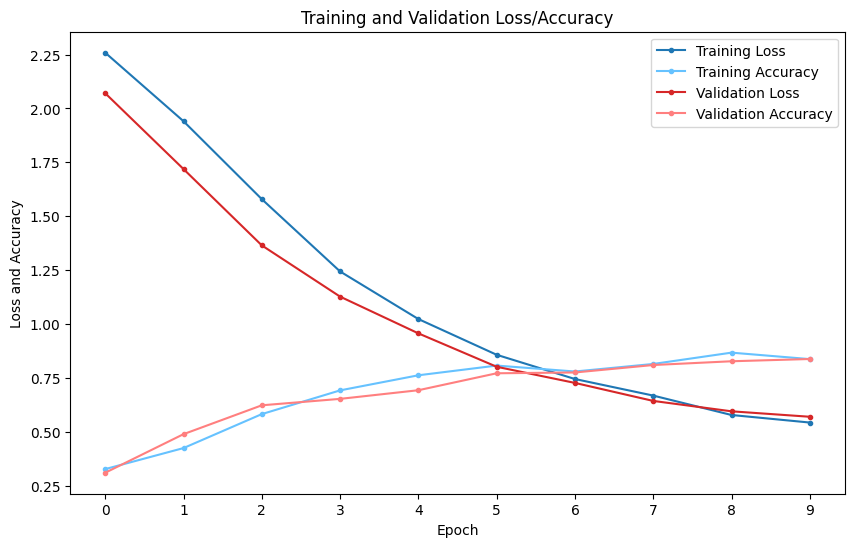


Test Sequence Length: 1000
Testing Standard LSTM:
Segment 01/10 | Loss: 0.5782 | Accuracy: 0.8376
Segment 02/10 | Loss: 0.5797 | Accuracy: 0.8359
Segment 03/10 | Loss: 0.5743 | Accuracy: 0.8374
Segment 04/10 | Loss: 0.5860 | Accuracy: 0.8359
Segment 05/10 | Loss: 0.5882 | Accuracy: 0.8298
Segment 06/10 | Loss: 0.5795 | Accuracy: 0.8418
Segment 07/10 | Loss: 0.5794 | Accuracy: 0.8397
Segment 08/10 | Loss: 0.5761 | Accuracy: 0.8407
Segment 09/10 | Loss: 0.5780 | Accuracy: 0.8356
Segment 10/10 | Loss: 0.5624 | Accuracy: 0.8477

Final Test Loss: 0.5782 | Final Test Accuracy: 0.8382
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2433 | Val Loss: 2.0608 | Training Accuracy: 0.3650 | Val Accuracy: 0.2929
Epoch 02 | Training Loss: 1.8996 | Val Loss: 1.6665 | Training Accuracy: 0.4000 | Val Accuracy: 0.4633
Epoch 03 | Training Loss: 1.5395 | Val Loss: 1.4017 | Training Accuracy: 0

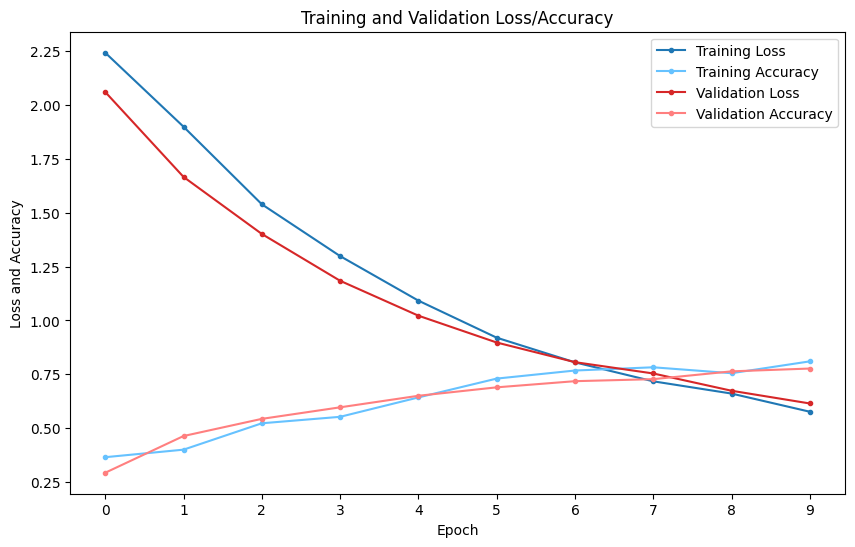


Test Sequence Length: 1000
Testing Multiplicative LSTM:
Segment 01/10 | Loss: 0.6252 | Accuracy: 0.7745
Segment 02/10 | Loss: 0.6197 | Accuracy: 0.7795
Segment 03/10 | Loss: 0.6110 | Accuracy: 0.7804
Segment 04/10 | Loss: 0.6260 | Accuracy: 0.7756
Segment 05/10 | Loss: 0.6290 | Accuracy: 0.7701
Segment 06/10 | Loss: 0.6247 | Accuracy: 0.7704
Segment 07/10 | Loss: 0.6236 | Accuracy: 0.7772
Segment 08/10 | Loss: 0.6211 | Accuracy: 0.7762
Segment 09/10 | Loss: 0.6252 | Accuracy: 0.7729
Segment 10/10 | Loss: 0.6131 | Accuracy: 0.7793

Final Test Loss: 0.6219 | Final Test Accuracy: 0.7756
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.3139 | Val Loss: 2.0270 | Training Accuracy: 0.2500 | Val Accuracy: 0.3747
Epoch 02 | Training Loss: 1.8647 | Val Loss: 1.6422 | Training Accuracy: 0.4500 | Val Accuracy: 0.5071
Epoch 03 | Training Loss: 1.5088 | Val Loss: 1.3331 | Training Accuracy: 0.

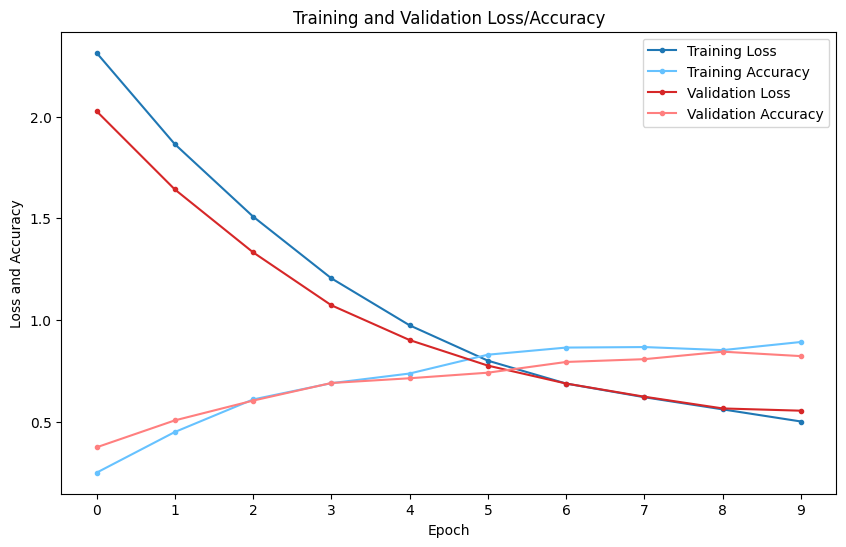


Test Sequence Length: 1000
Testing Standard GRU:
Segment 01/10 | Loss: 0.5516 | Accuracy: 0.8287
Segment 02/10 | Loss: 0.5508 | Accuracy: 0.8256
Segment 03/10 | Loss: 0.5540 | Accuracy: 0.8268
Segment 04/10 | Loss: 0.5508 | Accuracy: 0.8244
Segment 05/10 | Loss: 0.5474 | Accuracy: 0.8293
Segment 06/10 | Loss: 0.5523 | Accuracy: 0.8225
Segment 07/10 | Loss: 0.5531 | Accuracy: 0.8256
Segment 08/10 | Loss: 0.5540 | Accuracy: 0.8250
Segment 09/10 | Loss: 0.5524 | Accuracy: 0.8242
Segment 10/10 | Loss: 0.5456 | Accuracy: 0.8257

Final Test Loss: 0.5512 | Final Test Accuracy: 0.8258
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.3250 | Val Loss: 2.1944 | Training Accuracy: 0.2325 | Val Accuracy: 0.2192
Epoch 02 | Training Loss: 2.0753 | Val Loss: 1.9531 | Training Accuracy: 0.2525 | Val Accuracy: 0.2981
Epoch 03 | Training Loss: 1.8399 | Val Loss: 1.7655 | Training Accuracy: 0.3

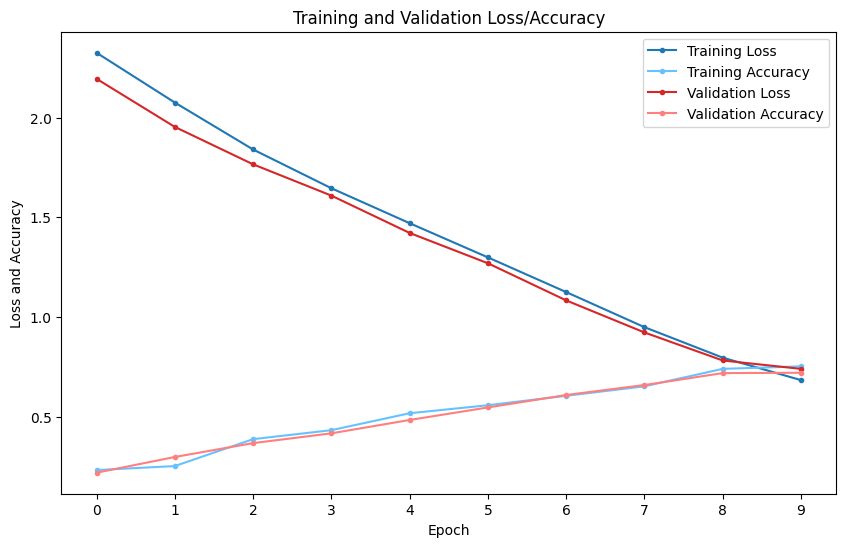


Test Sequence Length: 1000
Testing Multiplicative GRU:
Segment 01/10 | Loss: 0.7625 | Accuracy: 0.7165
Segment 02/10 | Loss: 0.7795 | Accuracy: 0.7018
Segment 03/10 | Loss: 0.7634 | Accuracy: 0.7114
Segment 04/10 | Loss: 0.7609 | Accuracy: 0.7134
Segment 05/10 | Loss: 0.7742 | Accuracy: 0.7083
Segment 06/10 | Loss: 0.7672 | Accuracy: 0.7103
Segment 07/10 | Loss: 0.7758 | Accuracy: 0.7047
Segment 08/10 | Loss: 0.7652 | Accuracy: 0.7111
Segment 09/10 | Loss: 0.7608 | Accuracy: 0.7104
Segment 10/10 | Loss: 0.7542 | Accuracy: 0.7095

Final Test Loss: 0.7664 | Final Test Accuracy: 0.7097
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 1/3 on sequence length of 1000 ***
Standard LSTM
Final Test Loss: 0.5782
Final Test Accuracy: 0.8382

Multiplicative LSTM
Final Test Loss: 0.6219
Final Test Accuracy: 0.7756

Standard GRU
Final Test Loss: 0.5512
Final Test Accuracy: 0.8258

Multiplicative GRU
Final Test

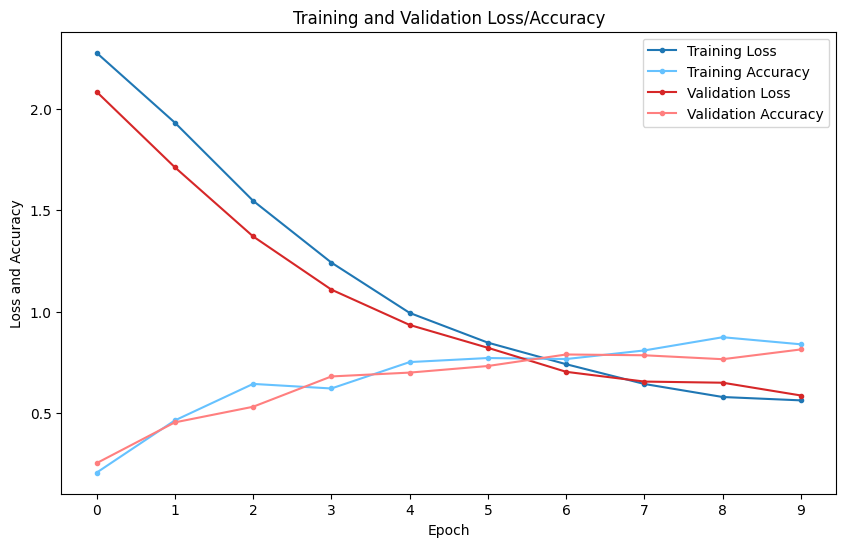


Test Sequence Length: 100
Testing Standard LSTM:

Final Test Loss: 0.5776 | Final Test Accuracy: 0.8253
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2716 | Val Loss: 2.0386 | Training Accuracy: 0.2200 | Val Accuracy: 0.4177
Epoch 02 | Training Loss: 1.8673 | Val Loss: 1.5800 | Training Accuracy: 0.4950 | Val Accuracy: 0.5364
Epoch 03 | Training Loss: 1.4283 | Val Loss: 1.2919 | Training Accuracy: 0.6075 | Val Accuracy: 0.5794
Epoch 04 | Training Loss: 1.1680 | Val Loss: 1.1201 | Training Accuracy: 0.6675 | Val Accuracy: 0.6192
Epoch 05 | Training Loss: 0.9754 | Val Loss: 0.9394 | Training Accuracy: 0.7100 | Val Accuracy: 0.6965
Epoch 06 | Training Loss: 0.8642 | Val Loss: 0.8194 | Training Accuracy: 0.6925 | Val Accuracy: 0.7263
Epoch 07 | Training Loss: 0.7334 | Val Loss: 0.7417 | Training Accuracy: 0.7850 | Val Accuracy: 0.7494
Epoch 08 | Training Loss: 0.6445 | Val L

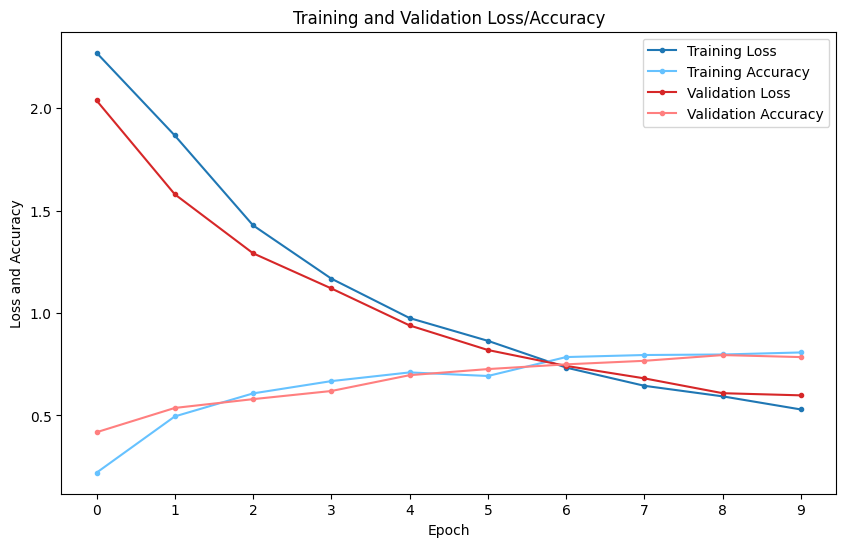


Test Sequence Length: 100
Testing Multiplicative LSTM:

Final Test Loss: 0.6079 | Final Test Accuracy: 0.7784
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.2871 | Val Loss: 1.9686 | Training Accuracy: 0.2050 | Val Accuracy: 0.4881
Epoch 02 | Training Loss: 1.8289 | Val Loss: 1.5828 | Training Accuracy: 0.5075 | Val Accuracy: 0.5284
Epoch 03 | Training Loss: 1.4426 | Val Loss: 1.2437 | Training Accuracy: 0.6375 | Val Accuracy: 0.6052
Epoch 04 | Training Loss: 1.1345 | Val Loss: 1.0047 | Training Accuracy: 0.7325 | Val Accuracy: 0.7034
Epoch 05 | Training Loss: 0.9141 | Val Loss: 0.8292 | Training Accuracy: 0.7375 | Val Accuracy: 0.7628
Epoch 06 | Training Loss: 0.7536 | Val Loss: 0.7155 | Training Accuracy: 0.8100 | Val Accuracy: 0.7849
Epoch 07 | Training Loss: 0.6577 | Val Loss: 0.6283 | Training Accuracy: 0.8400 | Val Accuracy: 0.8563
Epoch 08 | Training Loss: 0.5792 | Val Lo

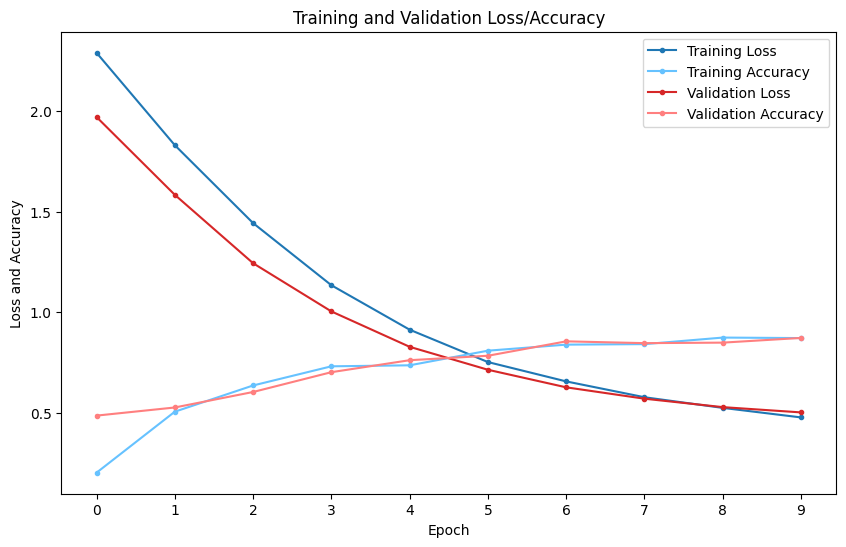


Test Sequence Length: 100
Testing Standard GRU:

Final Test Loss: 0.5082 | Final Test Accuracy: 0.8712
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.2710 | Val Loss: 2.0134 | Training Accuracy: 0.2525 | Val Accuracy: 0.2978
Epoch 02 | Training Loss: 1.8580 | Val Loss: 1.6887 | Training Accuracy: 0.3925 | Val Accuracy: 0.4101
Epoch 03 | Training Loss: 1.5456 | Val Loss: 1.4819 | Training Accuracy: 0.5475 | Val Accuracy: 0.4860
Epoch 04 | Training Loss: 1.3470 | Val Loss: 1.3132 | Training Accuracy: 0.5925 | Val Accuracy: 0.5403
Epoch 05 | Training Loss: 1.2047 | Val Loss: 1.1328 | Training Accuracy: 0.5925 | Val Accuracy: 0.6058
Epoch 06 | Training Loss: 1.0456 | Val Loss: 0.9992 | Training Accuracy: 0.6625 | Val Accuracy: 0.6574
Epoch 07 | Training Loss: 0.9175 | Val Loss: 0.9373 | Training Accuracy: 0.7050 | Val Accuracy: 0.6780
Epoch 08 | Training Loss: 0.8106 | Val Los

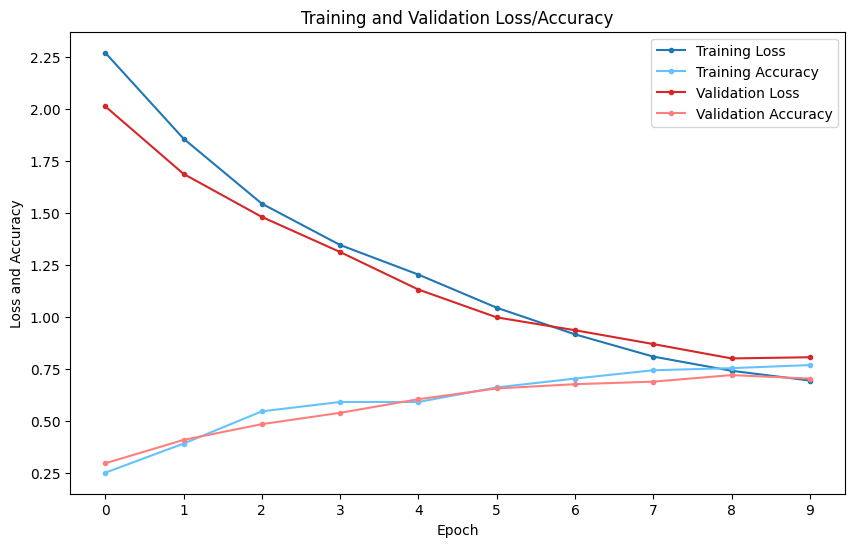


Test Sequence Length: 100
Testing Multiplicative GRU:

Final Test Loss: 0.8094 | Final Test Accuracy: 0.7066
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 2/3 on sequence length of 100 ***
Standard LSTM
Final Test Loss: 0.5776
Final Test Accuracy: 0.8253

Multiplicative LSTM
Final Test Loss: 0.6079
Final Test Accuracy: 0.7784

Standard GRU
Final Test Loss: 0.5082
Final Test Accuracy: 0.8712

Multiplicative GRU
Final Test Loss: 0.8094
Final Test Accuracy: 0.7066

Training Standard LSTM:
Epoch 01 | Training Loss: 2.3107 | Val Loss: 2.1517 | Training Accuracy: 0.3225 | Val Accuracy: 0.1991
Epoch 02 | Training Loss: 2.0481 | Val Loss: 1.8311 | Training Accuracy: 0.3825 | Val Accuracy: 0.4392
Epoch 03 | Training Loss: 1.6946 | Val Loss: 1.4946 | Training Accuracy: 0.5675 | Val Accuracy: 0.5833
Epoch 04 | Training Loss: 1.3749 | Val Loss: 1.2361 | Training Accuracy: 0.6200 | Val Accuracy: 0.6578
Epo

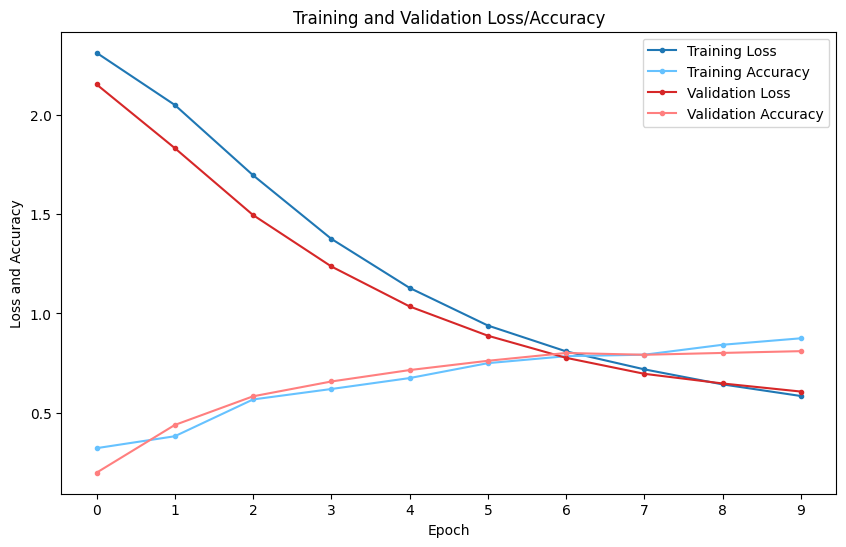


Test Sequence Length: 200
Testing Standard LSTM:
Segment 01/02 | Loss: 0.6276 | Accuracy: 0.8027
Segment 02/02 | Loss: 0.6065 | Accuracy: 0.8120

Final Test Loss: 0.6171 | Final Test Accuracy: 0.8074
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2540 | Val Loss: 2.0365 | Training Accuracy: 0.3150 | Val Accuracy: 0.3249
Epoch 02 | Training Loss: 1.9007 | Val Loss: 1.7434 | Training Accuracy: 0.4250 | Val Accuracy: 0.4140
Epoch 03 | Training Loss: 1.6296 | Val Loss: 1.5455 | Training Accuracy: 0.5025 | Val Accuracy: 0.4711
Epoch 04 | Training Loss: 1.4558 | Val Loss: 1.3562 | Training Accuracy: 0.5025 | Val Accuracy: 0.5476
Epoch 05 | Training Loss: 1.2663 | Val Loss: 1.2212 | Training Accuracy: 0.5775 | Val Accuracy: 0.5950
Epoch 06 | Training Loss: 1.1312 | Val Loss: 1.1117 | Training Accuracy: 0.6250 | Val Accuracy: 0.6290
Epoch 07 | Training Loss: 1.0248 | Val Loss: 1.

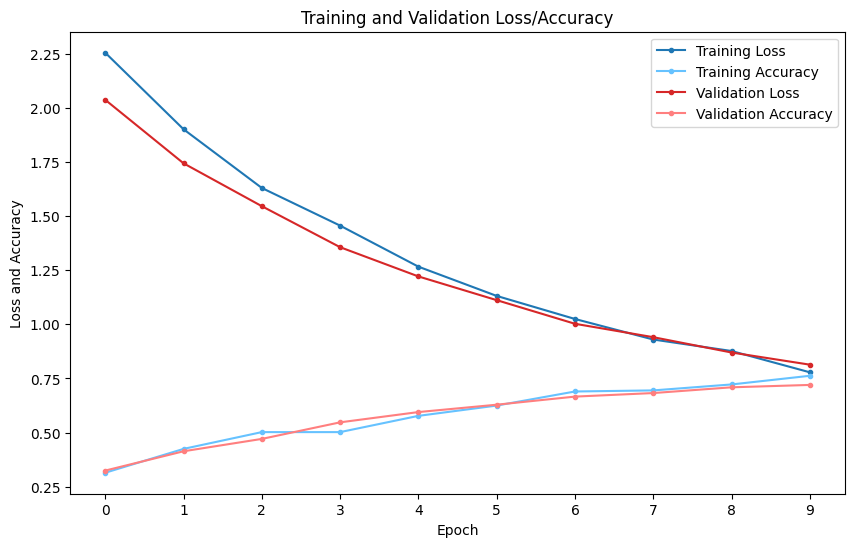


Test Sequence Length: 200
Testing Multiplicative LSTM:
Segment 01/02 | Loss: 0.8547 | Accuracy: 0.7032
Segment 02/02 | Loss: 0.8210 | Accuracy: 0.7183

Final Test Loss: 0.8379 | Final Test Accuracy: 0.7107
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.3036 | Val Loss: 2.0151 | Training Accuracy: 0.3275 | Val Accuracy: 0.3328
Epoch 02 | Training Loss: 1.8521 | Val Loss: 1.5843 | Training Accuracy: 0.5025 | Val Accuracy: 0.5341
Epoch 03 | Training Loss: 1.4448 | Val Loss: 1.2329 | Training Accuracy: 0.6225 | Val Accuracy: 0.6469
Epoch 04 | Training Loss: 1.1204 | Val Loss: 1.0097 | Training Accuracy: 0.7550 | Val Accuracy: 0.7023
Epoch 05 | Training Loss: 0.9298 | Val Loss: 0.8274 | Training Accuracy: 0.7575 | Val Accuracy: 0.7670
Epoch 06 | Training Loss: 0.7637 | Val Loss: 0.7130 | Training Accuracy: 0.8325 | Val Accuracy: 0.8092
Epoch 07 | Training Loss: 0.6684 | Val Loss: 0.6

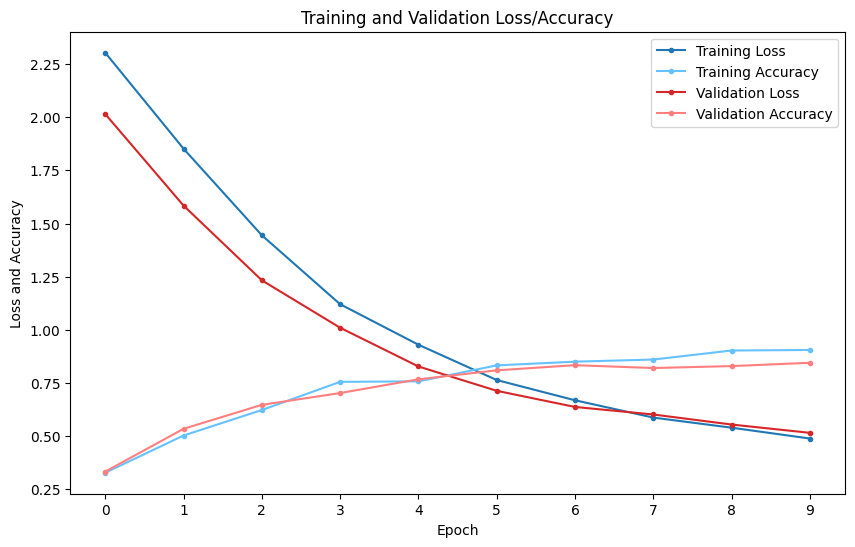


Test Sequence Length: 200
Testing Standard GRU:
Segment 01/02 | Loss: 0.5324 | Accuracy: 0.8391
Segment 02/02 | Loss: 0.5127 | Accuracy: 0.8446

Final Test Loss: 0.5226 | Final Test Accuracy: 0.8418
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.2605 | Val Loss: 1.9540 | Training Accuracy: 0.3000 | Val Accuracy: 0.3610
Epoch 02 | Training Loss: 1.8241 | Val Loss: 1.6268 | Training Accuracy: 0.4450 | Val Accuracy: 0.4697
Epoch 03 | Training Loss: 1.5376 | Val Loss: 1.4383 | Training Accuracy: 0.4725 | Val Accuracy: 0.5191
Epoch 04 | Training Loss: 1.3508 | Val Loss: 1.3660 | Training Accuracy: 0.5450 | Val Accuracy: 0.5328
Epoch 05 | Training Loss: 1.2076 | Val Loss: 1.2456 | Training Accuracy: 0.6050 | Val Accuracy: 0.5644
Epoch 06 | Training Loss: 1.1123 | Val Loss: 1.1371 | Training Accuracy: 0.5925 | Val Accuracy: 0.6062
Epoch 07 | Training Loss: 1.0083 | Val Loss: 1.05

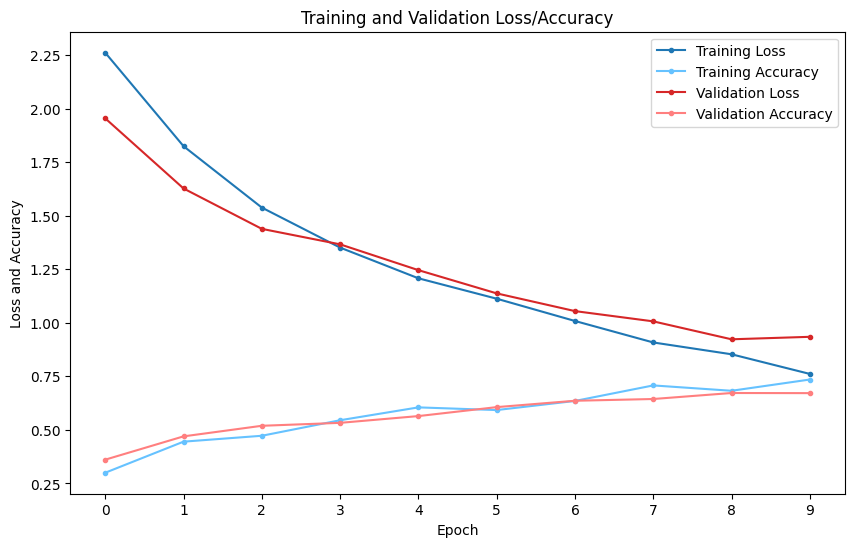


Test Sequence Length: 200
Testing Multiplicative GRU:
Segment 01/02 | Loss: 0.9516 | Accuracy: 0.6668
Segment 02/02 | Loss: 0.9416 | Accuracy: 0.6688

Final Test Loss: 0.9466 | Final Test Accuracy: 0.6678
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 2/3 on sequence length of 200 ***
Standard LSTM
Final Test Loss: 0.6171
Final Test Accuracy: 0.8074

Multiplicative LSTM
Final Test Loss: 0.8379
Final Test Accuracy: 0.7107

Standard GRU
Final Test Loss: 0.5226
Final Test Accuracy: 0.8418

Multiplicative GRU
Final Test Loss: 0.9466
Final Test Accuracy: 0.6678

Training Standard LSTM:
Epoch 01 | Training Loss: 2.2881 | Val Loss: 2.1259 | Training Accuracy: 0.1975 | Val Accuracy: 0.3580
Epoch 02 | Training Loss: 1.9895 | Val Loss: 1.7697 | Training Accuracy: 0.4425 | Val Accuracy: 0.4756
Epoch 03 | Training Loss: 1.6104 | Val Loss: 1.4013 | Training Accuracy: 0.5900 | Val Accuracy: 0.6084
Epoch 04 |

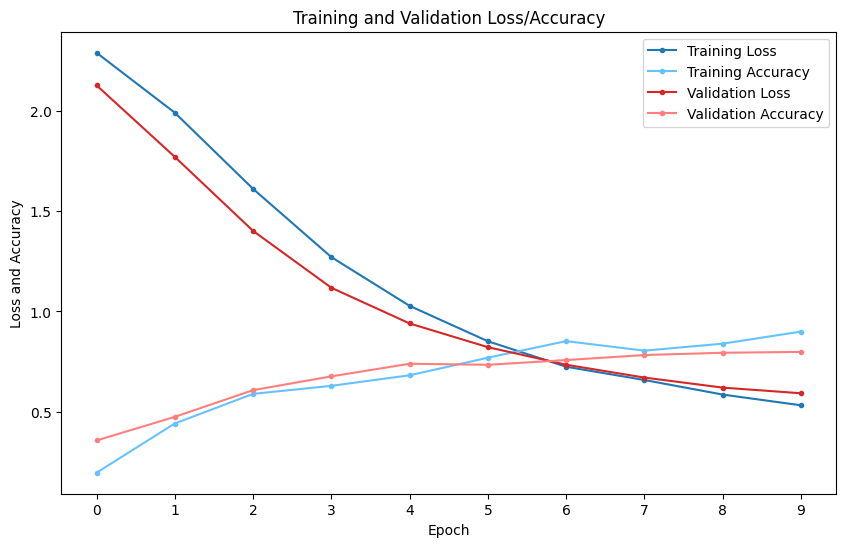


Test Sequence Length: 500
Testing Standard LSTM:
Segment 01/05 | Loss: 0.5977 | Accuracy: 0.8002
Segment 02/05 | Loss: 0.6059 | Accuracy: 0.7987
Segment 03/05 | Loss: 0.5959 | Accuracy: 0.8049
Segment 04/05 | Loss: 0.5985 | Accuracy: 0.8014
Segment 05/05 | Loss: 0.5763 | Accuracy: 0.8103

Final Test Loss: 0.5948 | Final Test Accuracy: 0.8031
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2258 | Val Loss: 1.9999 | Training Accuracy: 0.3025 | Val Accuracy: 0.3387
Epoch 02 | Training Loss: 1.8614 | Val Loss: 1.6502 | Training Accuracy: 0.4675 | Val Accuracy: 0.4685
Epoch 03 | Training Loss: 1.5243 | Val Loss: 1.4224 | Training Accuracy: 0.5100 | Val Accuracy: 0.5212
Epoch 04 | Training Loss: 1.2800 | Val Loss: 1.2206 | Training Accuracy: 0.6150 | Val Accuracy: 0.5957
Epoch 05 | Training Loss: 1.1133 | Val Loss: 1.0439 | Training Accuracy: 0.6500 | Val Accuracy: 0.6534
Epoch 

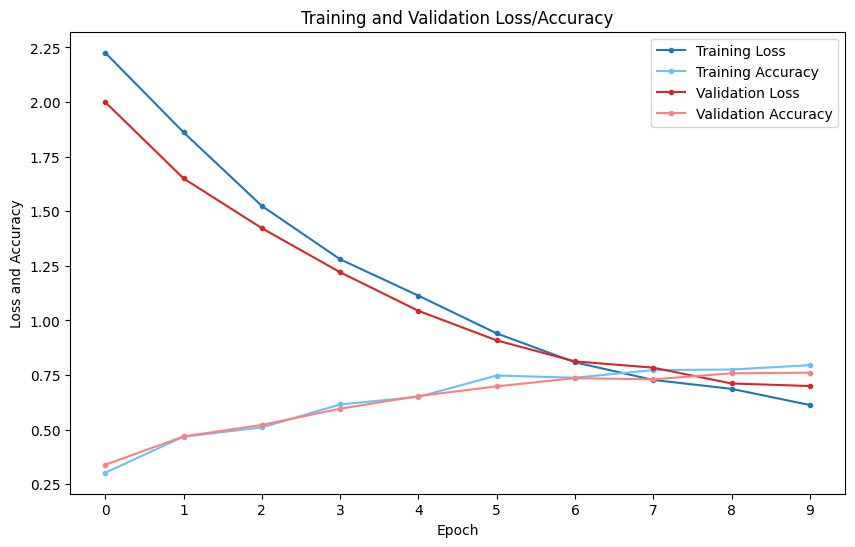


Test Sequence Length: 500
Testing Multiplicative LSTM:
Segment 01/05 | Loss: 0.7027 | Accuracy: 0.7640
Segment 02/05 | Loss: 0.7119 | Accuracy: 0.7567
Segment 03/05 | Loss: 0.7055 | Accuracy: 0.7620
Segment 04/05 | Loss: 0.7115 | Accuracy: 0.7634
Segment 05/05 | Loss: 0.6985 | Accuracy: 0.7582

Final Test Loss: 0.7060 | Final Test Accuracy: 0.7609
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.2482 | Val Loss: 1.9187 | Training Accuracy: 0.3225 | Val Accuracy: 0.4678
Epoch 02 | Training Loss: 1.7398 | Val Loss: 1.4618 | Training Accuracy: 0.5325 | Val Accuracy: 0.6178
Epoch 03 | Training Loss: 1.3330 | Val Loss: 1.1280 | Training Accuracy: 0.6875 | Val Accuracy: 0.6537
Epoch 04 | Training Loss: 1.0226 | Val Loss: 0.9029 | Training Accuracy: 0.7350 | Val Accuracy: 0.7261
Epoch 05 | Training Loss: 0.8345 | Val Loss: 0.7837 | Training Accuracy: 0.7600 | Val Accuracy: 0.7332
Epoch 0

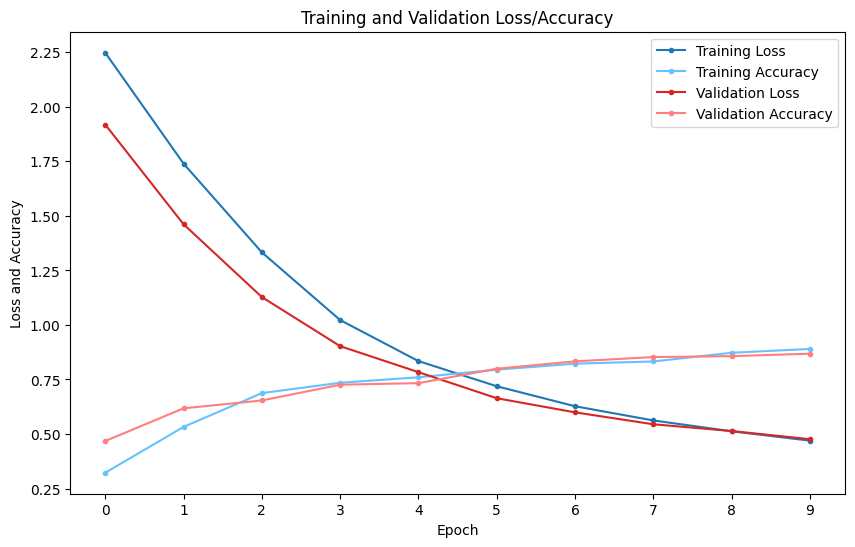


Test Sequence Length: 500
Testing Standard GRU:
Segment 01/05 | Loss: 0.5020 | Accuracy: 0.8557
Segment 02/05 | Loss: 0.5053 | Accuracy: 0.8561
Segment 03/05 | Loss: 0.5042 | Accuracy: 0.8550
Segment 04/05 | Loss: 0.4973 | Accuracy: 0.8551
Segment 05/05 | Loss: 0.4945 | Accuracy: 0.8531

Final Test Loss: 0.5007 | Final Test Accuracy: 0.8550
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.2826 | Val Loss: 2.0219 | Training Accuracy: 0.3350 | Val Accuracy: 0.3116
Epoch 02 | Training Loss: 1.8705 | Val Loss: 1.6804 | Training Accuracy: 0.4000 | Val Accuracy: 0.4498
Epoch 03 | Training Loss: 1.5792 | Val Loss: 1.4179 | Training Accuracy: 0.4925 | Val Accuracy: 0.5159
Epoch 04 | Training Loss: 1.3276 | Val Loss: 1.2480 | Training Accuracy: 0.5475 | Val Accuracy: 0.5711
Epoch 05 | Training Loss: 1.1458 | Val Loss: 1.1010 | Training Accuracy: 0.6100 | Val Accuracy: 0.6187
Epoch 06

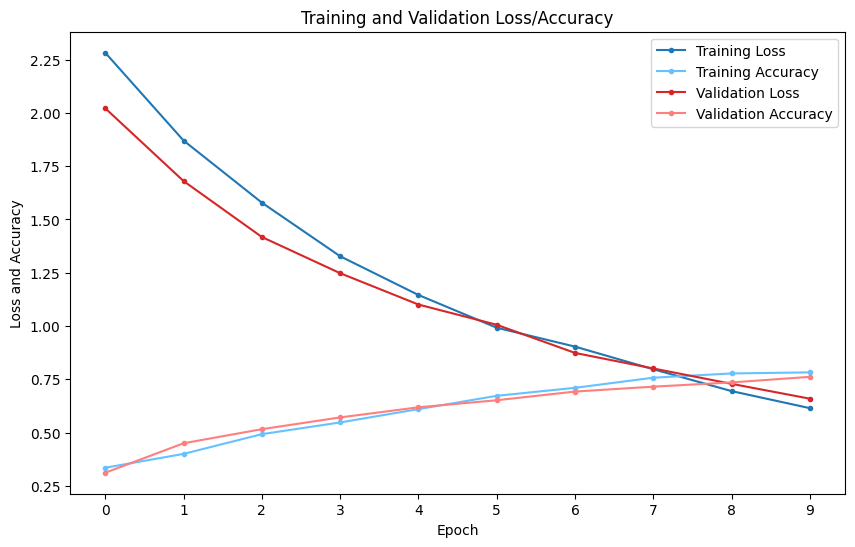


Test Sequence Length: 500
Testing Multiplicative GRU:
Segment 01/05 | Loss: 0.6679 | Accuracy: 0.7552
Segment 02/05 | Loss: 0.6652 | Accuracy: 0.7611
Segment 03/05 | Loss: 0.6714 | Accuracy: 0.7535
Segment 04/05 | Loss: 0.6710 | Accuracy: 0.7549
Segment 05/05 | Loss: 0.6707 | Accuracy: 0.7492

Final Test Loss: 0.6692 | Final Test Accuracy: 0.7548
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 2/3 on sequence length of 500 ***
Standard LSTM
Final Test Loss: 0.5948
Final Test Accuracy: 0.8031

Multiplicative LSTM
Final Test Loss: 0.7060
Final Test Accuracy: 0.7609

Standard GRU
Final Test Loss: 0.5007
Final Test Accuracy: 0.8550

Multiplicative GRU
Final Test Loss: 0.6692
Final Test Accuracy: 0.7548

Training Standard LSTM:
Epoch 01 | Training Loss: 2.2767 | Val Loss: 2.0969 | Training Accuracy: 0.2750 | Val Accuracy: 0.2720
Epoch 02 | Training Loss: 1.9409 | Val Loss: 1.6942 | Training Accuracy:

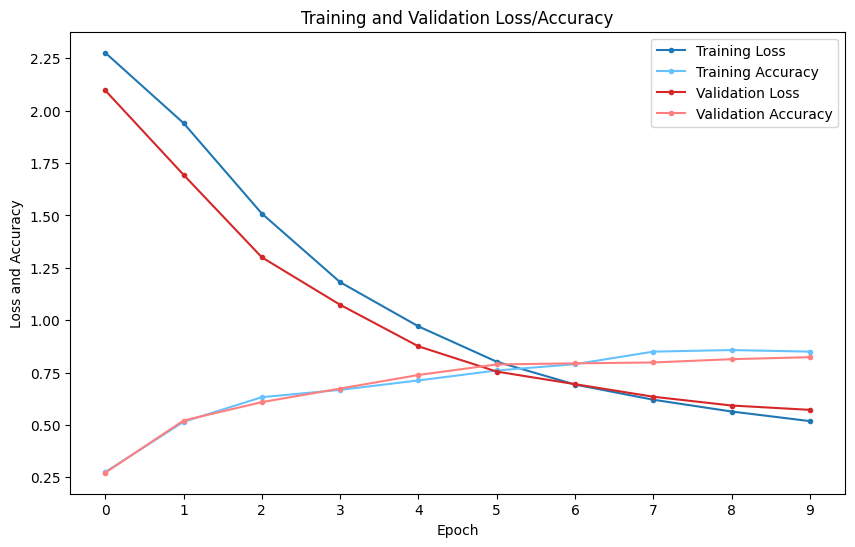


Test Sequence Length: 1000
Testing Standard LSTM:
Segment 01/10 | Loss: 0.5845 | Accuracy: 0.8133
Segment 02/10 | Loss: 0.5801 | Accuracy: 0.8193
Segment 03/10 | Loss: 0.5914 | Accuracy: 0.8045
Segment 04/10 | Loss: 0.5776 | Accuracy: 0.8185
Segment 05/10 | Loss: 0.5831 | Accuracy: 0.8130
Segment 06/10 | Loss: 0.5859 | Accuracy: 0.8165
Segment 07/10 | Loss: 0.5852 | Accuracy: 0.8160
Segment 08/10 | Loss: 0.5851 | Accuracy: 0.8103
Segment 09/10 | Loss: 0.5824 | Accuracy: 0.8163
Segment 10/10 | Loss: 0.5680 | Accuracy: 0.8209

Final Test Loss: 0.5823 | Final Test Accuracy: 0.8149
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2729 | Val Loss: 2.0793 | Training Accuracy: 0.3400 | Val Accuracy: 0.3272
Epoch 02 | Training Loss: 1.9415 | Val Loss: 1.7108 | Training Accuracy: 0.3925 | Val Accuracy: 0.4527
Epoch 03 | Training Loss: 1.6286 | Val Loss: 1.4805 | Training Accuracy: 0

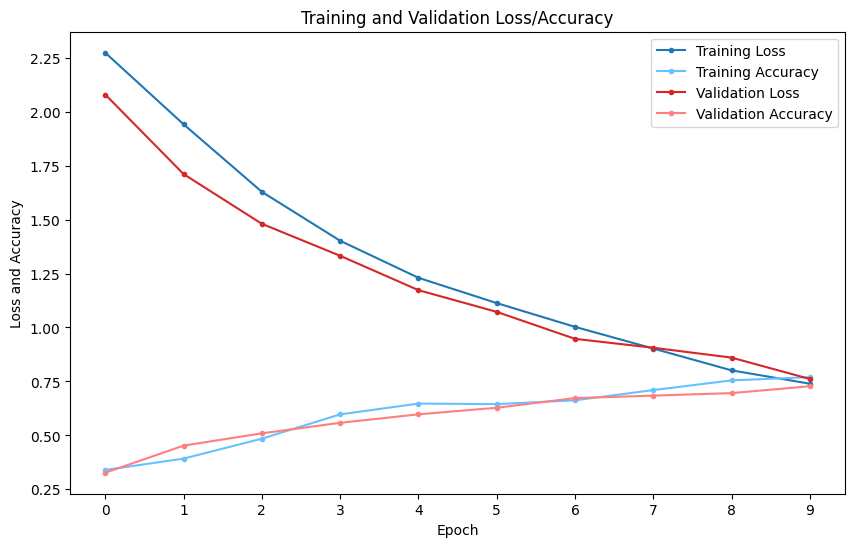


Test Sequence Length: 1000
Testing Multiplicative LSTM:
Segment 01/10 | Loss: 0.8066 | Accuracy: 0.7060
Segment 02/10 | Loss: 0.7894 | Accuracy: 0.7175
Segment 03/10 | Loss: 0.7888 | Accuracy: 0.7160
Segment 04/10 | Loss: 0.7928 | Accuracy: 0.7106
Segment 05/10 | Loss: 0.7907 | Accuracy: 0.7149
Segment 06/10 | Loss: 0.7842 | Accuracy: 0.7175
Segment 07/10 | Loss: 0.7908 | Accuracy: 0.7132
Segment 08/10 | Loss: 0.7833 | Accuracy: 0.7172
Segment 09/10 | Loss: 0.7938 | Accuracy: 0.7141
Segment 10/10 | Loss: 0.7834 | Accuracy: 0.7156

Final Test Loss: 0.7904 | Final Test Accuracy: 0.7143
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.3006 | Val Loss: 2.0133 | Training Accuracy: 0.3375 | Val Accuracy: 0.4150
Epoch 02 | Training Loss: 1.8463 | Val Loss: 1.6036 | Training Accuracy: 0.4450 | Val Accuracy: 0.5457
Epoch 03 | Training Loss: 1.4713 | Val Loss: 1.2588 | Training Accuracy: 0.

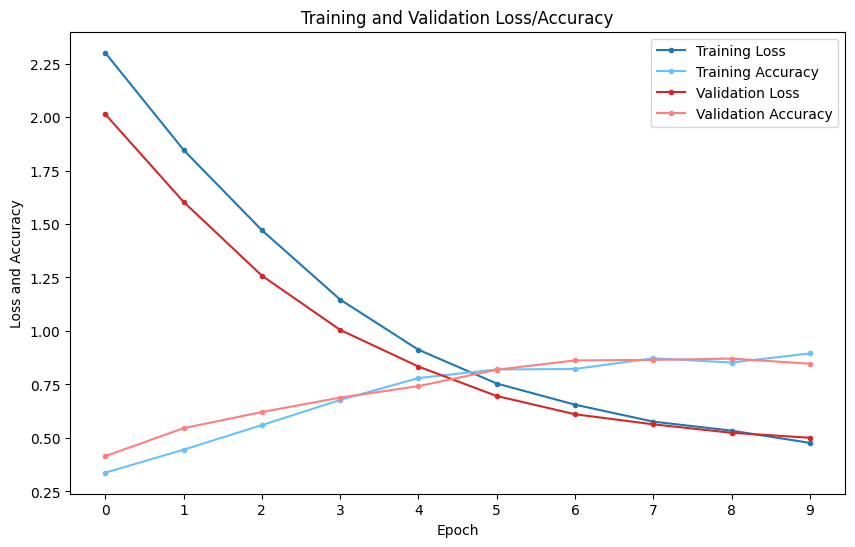


Test Sequence Length: 1000
Testing Standard GRU:
Segment 01/10 | Loss: 0.5183 | Accuracy: 0.8376
Segment 02/10 | Loss: 0.5139 | Accuracy: 0.8441
Segment 03/10 | Loss: 0.5202 | Accuracy: 0.8378
Segment 04/10 | Loss: 0.5148 | Accuracy: 0.8373
Segment 05/10 | Loss: 0.5192 | Accuracy: 0.8384
Segment 06/10 | Loss: 0.5170 | Accuracy: 0.8415
Segment 07/10 | Loss: 0.5210 | Accuracy: 0.8405
Segment 08/10 | Loss: 0.5134 | Accuracy: 0.8422
Segment 09/10 | Loss: 0.5177 | Accuracy: 0.8436
Segment 10/10 | Loss: 0.5008 | Accuracy: 0.8465

Final Test Loss: 0.5156 | Final Test Accuracy: 0.8409
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.3266 | Val Loss: 2.1270 | Training Accuracy: 0.2525 | Val Accuracy: 0.2797
Epoch 02 | Training Loss: 1.9509 | Val Loss: 1.7322 | Training Accuracy: 0.3900 | Val Accuracy: 0.4121
Epoch 03 | Training Loss: 1.5949 | Val Loss: 1.4409 | Training Accuracy: 0.4

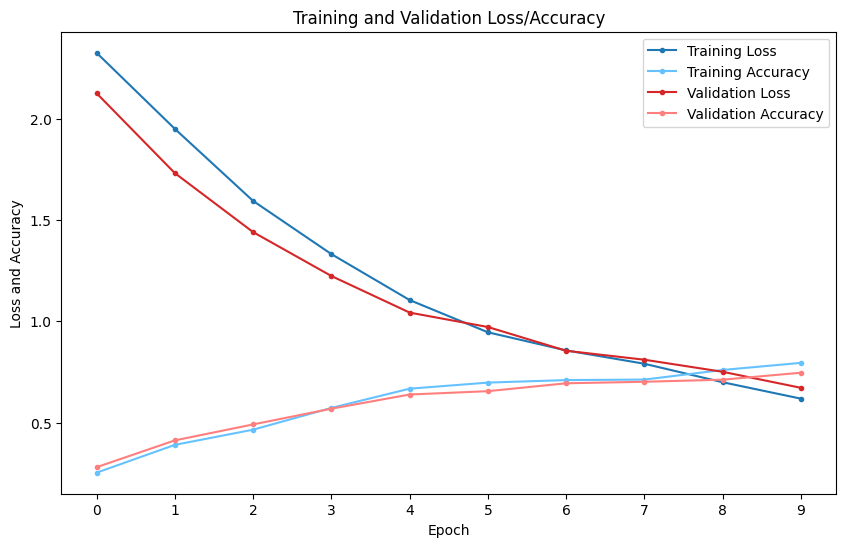


Test Sequence Length: 1000
Testing Multiplicative GRU:
Segment 01/10 | Loss: 0.6842 | Accuracy: 0.7423
Segment 02/10 | Loss: 0.6935 | Accuracy: 0.7322
Segment 03/10 | Loss: 0.6961 | Accuracy: 0.7354
Segment 04/10 | Loss: 0.7106 | Accuracy: 0.7276
Segment 05/10 | Loss: 0.6924 | Accuracy: 0.7373
Segment 06/10 | Loss: 0.7160 | Accuracy: 0.7217
Segment 07/10 | Loss: 0.6982 | Accuracy: 0.7362
Segment 08/10 | Loss: 0.6981 | Accuracy: 0.7330
Segment 09/10 | Loss: 0.7021 | Accuracy: 0.7268
Segment 10/10 | Loss: 0.6964 | Accuracy: 0.7348

Final Test Loss: 0.6988 | Final Test Accuracy: 0.7327
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 2/3 on sequence length of 1000 ***
Standard LSTM
Final Test Loss: 0.5823
Final Test Accuracy: 0.8149

Multiplicative LSTM
Final Test Loss: 0.7904
Final Test Accuracy: 0.7143

Standard GRU
Final Test Loss: 0.5156
Final Test Accuracy: 0.8409

Multiplicative GRU
Final Test

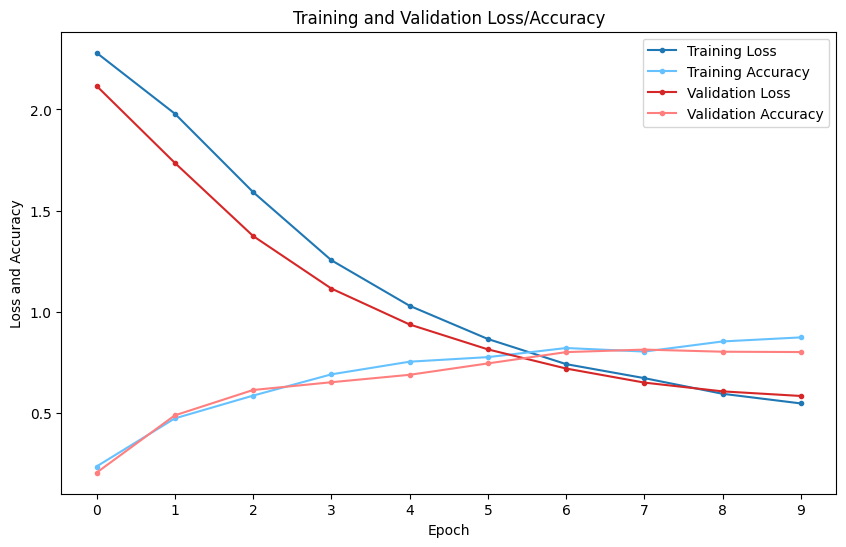


Test Sequence Length: 100
Testing Standard LSTM:

Final Test Loss: 0.5912 | Final Test Accuracy: 0.8030
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2483 | Val Loss: 2.0002 | Training Accuracy: 0.3775 | Val Accuracy: 0.3790
Epoch 02 | Training Loss: 1.8186 | Val Loss: 1.5944 | Training Accuracy: 0.4950 | Val Accuracy: 0.4870
Epoch 03 | Training Loss: 1.4448 | Val Loss: 1.3555 | Training Accuracy: 0.5875 | Val Accuracy: 0.5408
Epoch 04 | Training Loss: 1.2234 | Val Loss: 1.1170 | Training Accuracy: 0.6200 | Val Accuracy: 0.6306
Epoch 05 | Training Loss: 1.0286 | Val Loss: 0.9800 | Training Accuracy: 0.6850 | Val Accuracy: 0.6692
Epoch 06 | Training Loss: 0.8759 | Val Loss: 0.8971 | Training Accuracy: 0.7325 | Val Accuracy: 0.6945
Epoch 07 | Training Loss: 0.8067 | Val Loss: 0.8682 | Training Accuracy: 0.7125 | Val Accuracy: 0.6922
Epoch 08 | Training Loss: 0.7508 | Val L

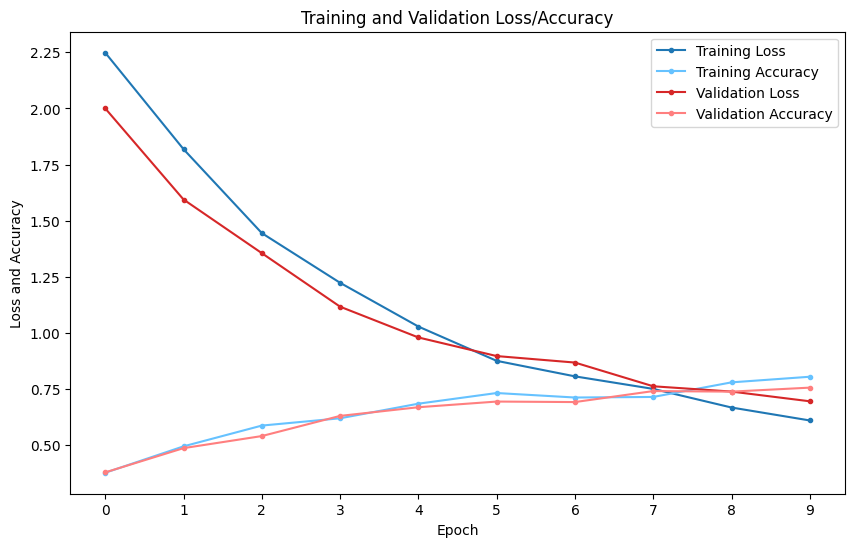


Test Sequence Length: 100
Testing Multiplicative LSTM:

Final Test Loss: 0.6925 | Final Test Accuracy: 0.7576
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.2608 | Val Loss: 1.9527 | Training Accuracy: 0.2650 | Val Accuracy: 0.4660
Epoch 02 | Training Loss: 1.8012 | Val Loss: 1.5547 | Training Accuracy: 0.4875 | Val Accuracy: 0.5724
Epoch 03 | Training Loss: 1.4030 | Val Loss: 1.2070 | Training Accuracy: 0.6450 | Val Accuracy: 0.6589
Epoch 04 | Training Loss: 1.0844 | Val Loss: 0.9590 | Training Accuracy: 0.7400 | Val Accuracy: 0.7314
Epoch 05 | Training Loss: 0.8693 | Val Loss: 0.7909 | Training Accuracy: 0.8075 | Val Accuracy: 0.7799
Epoch 06 | Training Loss: 0.7314 | Val Loss: 0.6847 | Training Accuracy: 0.8275 | Val Accuracy: 0.8241
Epoch 07 | Training Loss: 0.6284 | Val Loss: 0.6135 | Training Accuracy: 0.8250 | Val Accuracy: 0.8160
Epoch 08 | Training Loss: 0.5618 | Val Lo

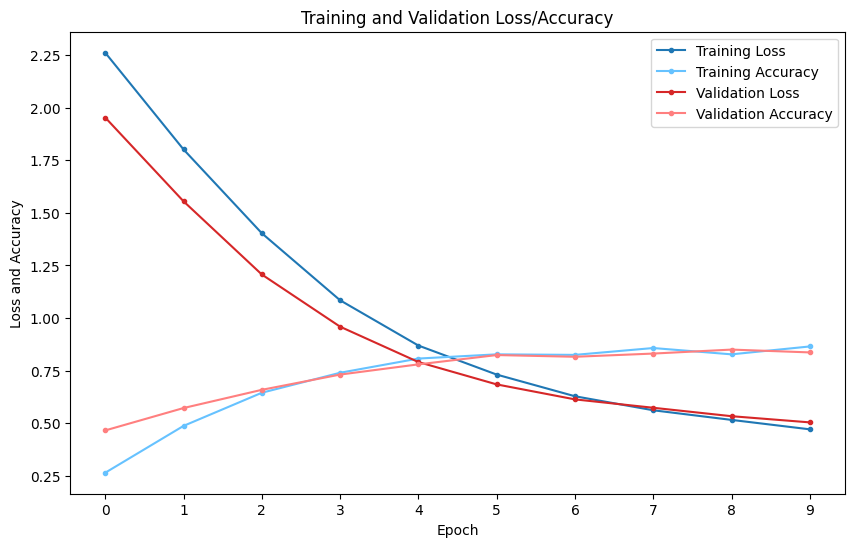


Test Sequence Length: 100
Testing Standard GRU:

Final Test Loss: 0.5225 | Final Test Accuracy: 0.8250
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.3103 | Val Loss: 2.0732 | Training Accuracy: 0.2125 | Val Accuracy: 0.3063
Epoch 02 | Training Loss: 1.9762 | Val Loss: 1.8051 | Training Accuracy: 0.3500 | Val Accuracy: 0.4043
Epoch 03 | Training Loss: 1.7230 | Val Loss: 1.5637 | Training Accuracy: 0.4475 | Val Accuracy: 0.4671
Epoch 04 | Training Loss: 1.4686 | Val Loss: 1.3969 | Training Accuracy: 0.5175 | Val Accuracy: 0.5173
Epoch 05 | Training Loss: 1.3370 | Val Loss: 1.1929 | Training Accuracy: 0.5075 | Val Accuracy: 0.5886
Epoch 06 | Training Loss: 1.1405 | Val Loss: 1.1190 | Training Accuracy: 0.6600 | Val Accuracy: 0.6031
Epoch 07 | Training Loss: 1.0108 | Val Loss: 0.9908 | Training Accuracy: 0.6750 | Val Accuracy: 0.6606
Epoch 08 | Training Loss: 0.8698 | Val Los

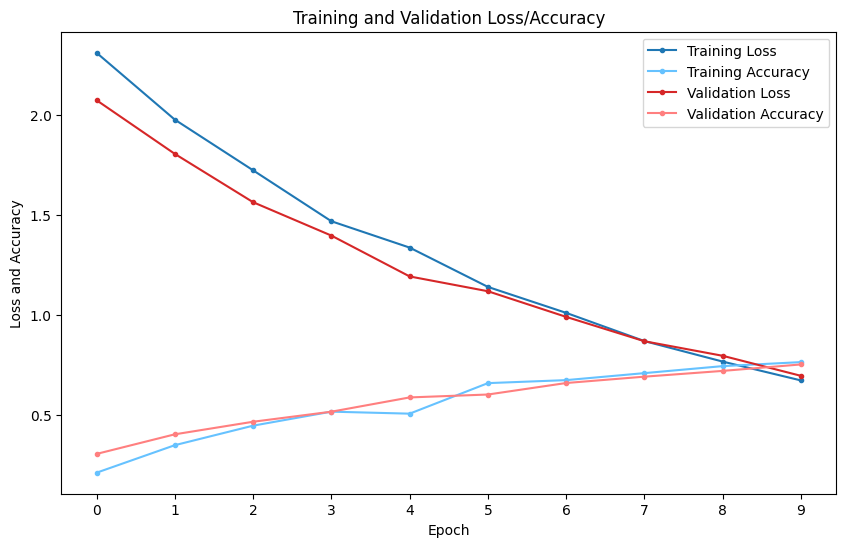


Test Sequence Length: 100
Testing Multiplicative GRU:

Final Test Loss: 0.6916 | Final Test Accuracy: 0.7516
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 3/3 on sequence length of 100 ***
Standard LSTM
Final Test Loss: 0.5912
Final Test Accuracy: 0.8030

Multiplicative LSTM
Final Test Loss: 0.6925
Final Test Accuracy: 0.7576

Standard GRU
Final Test Loss: 0.5225
Final Test Accuracy: 0.8250

Multiplicative GRU
Final Test Loss: 0.6916
Final Test Accuracy: 0.7516

Training Standard LSTM:
Epoch 01 | Training Loss: 2.2927 | Val Loss: 2.1333 | Training Accuracy: 0.3325 | Val Accuracy: 0.3636
Epoch 02 | Training Loss: 2.0120 | Val Loss: 1.7826 | Training Accuracy: 0.4325 | Val Accuracy: 0.4912
Epoch 03 | Training Loss: 1.6337 | Val Loss: 1.4430 | Training Accuracy: 0.5350 | Val Accuracy: 0.5700
Epoch 04 | Training Loss: 1.3218 | Val Loss: 1.1994 | Training Accuracy: 0.6025 | Val Accuracy: 0.6276
Epo

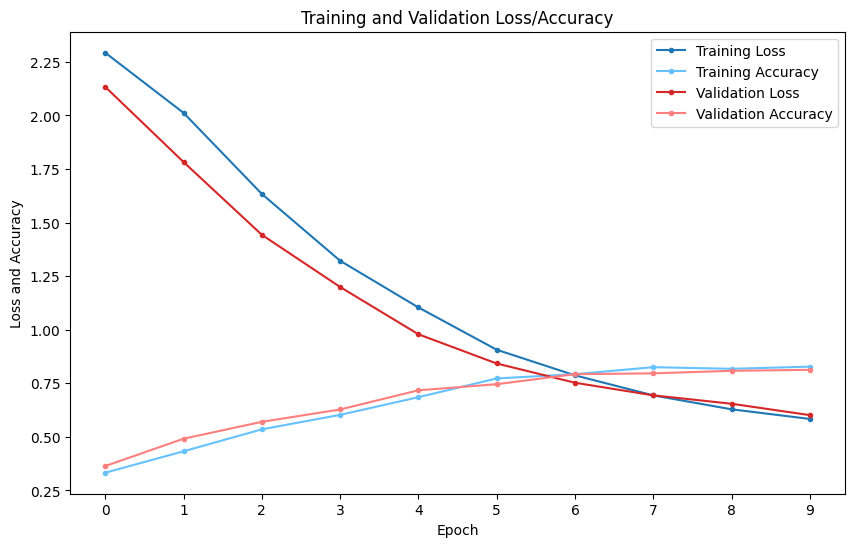


Test Sequence Length: 200
Testing Standard LSTM:
Segment 01/02 | Loss: 0.6189 | Accuracy: 0.8030
Segment 02/02 | Loss: 0.5924 | Accuracy: 0.8184

Final Test Loss: 0.6056 | Final Test Accuracy: 0.8107
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2558 | Val Loss: 2.0188 | Training Accuracy: 0.2725 | Val Accuracy: 0.3522
Epoch 02 | Training Loss: 1.8613 | Val Loss: 1.6049 | Training Accuracy: 0.4700 | Val Accuracy: 0.4774
Epoch 03 | Training Loss: 1.4669 | Val Loss: 1.3237 | Training Accuracy: 0.5275 | Val Accuracy: 0.5531
Epoch 04 | Training Loss: 1.2051 | Val Loss: 1.1308 | Training Accuracy: 0.5850 | Val Accuracy: 0.6099
Epoch 05 | Training Loss: 1.0151 | Val Loss: 0.9692 | Training Accuracy: 0.6950 | Val Accuracy: 0.6815
Epoch 06 | Training Loss: 0.8691 | Val Loss: 0.8849 | Training Accuracy: 0.7500 | Val Accuracy: 0.7052
Epoch 07 | Training Loss: 0.7795 | Val Loss: 0.

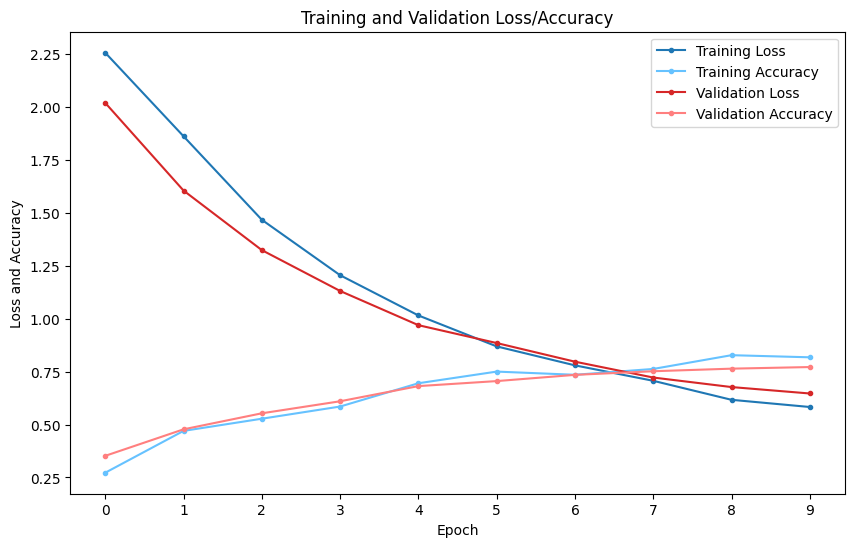


Test Sequence Length: 200
Testing Multiplicative LSTM:
Segment 01/02 | Loss: 0.6394 | Accuracy: 0.7714
Segment 02/02 | Loss: 0.6323 | Accuracy: 0.7747

Final Test Loss: 0.6358 | Final Test Accuracy: 0.7731
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.2769 | Val Loss: 1.9613 | Training Accuracy: 0.3175 | Val Accuracy: 0.3515
Epoch 02 | Training Loss: 1.8054 | Val Loss: 1.5583 | Training Accuracy: 0.5125 | Val Accuracy: 0.5534
Epoch 03 | Training Loss: 1.4243 | Val Loss: 1.2275 | Training Accuracy: 0.6650 | Val Accuracy: 0.6463
Epoch 04 | Training Loss: 1.1256 | Val Loss: 0.9955 | Training Accuracy: 0.6650 | Val Accuracy: 0.7111
Epoch 05 | Training Loss: 0.9090 | Val Loss: 0.8203 | Training Accuracy: 0.7400 | Val Accuracy: 0.7639
Epoch 06 | Training Loss: 0.7543 | Val Loss: 0.7119 | Training Accuracy: 0.8050 | Val Accuracy: 0.7877
Epoch 07 | Training Loss: 0.6601 | Val Loss: 0.6

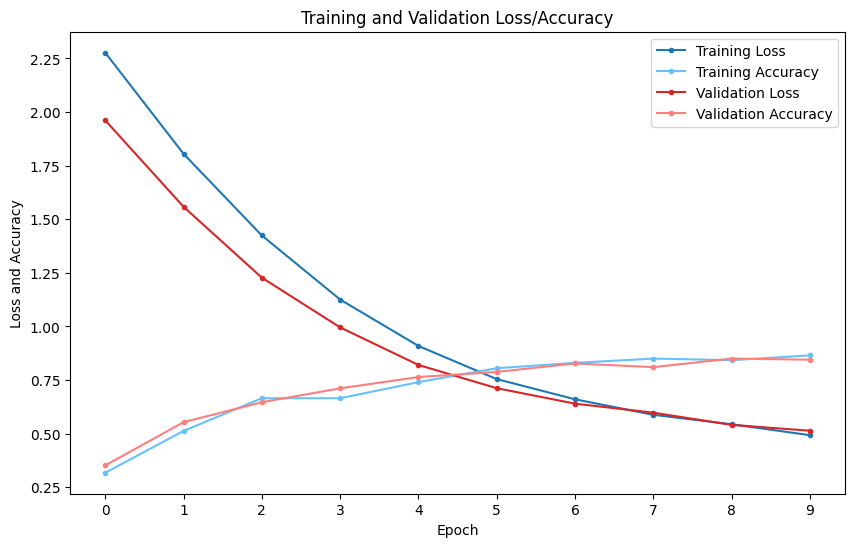


Test Sequence Length: 200
Testing Standard GRU:
Segment 01/02 | Loss: 0.5281 | Accuracy: 0.8402
Segment 02/02 | Loss: 0.5137 | Accuracy: 0.8424

Final Test Loss: 0.5209 | Final Test Accuracy: 0.8413
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.3419 | Val Loss: 2.1047 | Training Accuracy: 0.1650 | Val Accuracy: 0.2972
Epoch 02 | Training Loss: 1.9479 | Val Loss: 1.7641 | Training Accuracy: 0.4550 | Val Accuracy: 0.3990
Epoch 03 | Training Loss: 1.6095 | Val Loss: 1.4288 | Training Accuracy: 0.4675 | Val Accuracy: 0.5080
Epoch 04 | Training Loss: 1.3034 | Val Loss: 1.2193 | Training Accuracy: 0.5650 | Val Accuracy: 0.5779
Epoch 05 | Training Loss: 1.0647 | Val Loss: 1.0049 | Training Accuracy: 0.6725 | Val Accuracy: 0.6452
Epoch 06 | Training Loss: 0.8764 | Val Loss: 0.8525 | Training Accuracy: 0.7600 | Val Accuracy: 0.7017
Epoch 07 | Training Loss: 0.7641 | Val Loss: 0.80

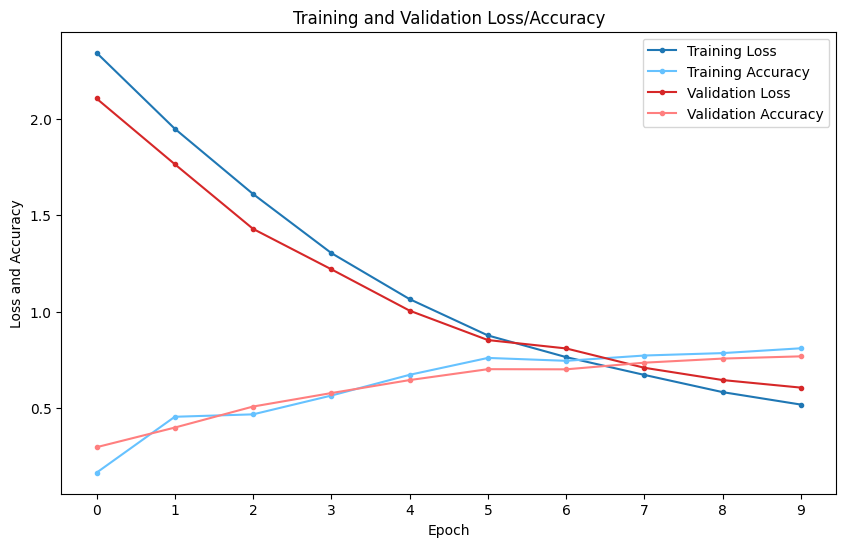


Test Sequence Length: 200
Testing Multiplicative GRU:
Segment 01/02 | Loss: 0.6052 | Accuracy: 0.7665
Segment 02/02 | Loss: 0.5887 | Accuracy: 0.7789

Final Test Loss: 0.5970 | Final Test Accuracy: 0.7727
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 3/3 on sequence length of 200 ***
Standard LSTM
Final Test Loss: 0.6056
Final Test Accuracy: 0.8107

Multiplicative LSTM
Final Test Loss: 0.6358
Final Test Accuracy: 0.7731

Standard GRU
Final Test Loss: 0.5209
Final Test Accuracy: 0.8413

Multiplicative GRU
Final Test Loss: 0.5970
Final Test Accuracy: 0.7727

Training Standard LSTM:
Epoch 01 | Training Loss: 2.2590 | Val Loss: 2.0698 | Training Accuracy: 0.3625 | Val Accuracy: 0.3661
Epoch 02 | Training Loss: 1.8946 | Val Loss: 1.6832 | Training Accuracy: 0.5550 | Val Accuracy: 0.4382
Epoch 03 | Training Loss: 1.5239 | Val Loss: 1.3444 | Training Accuracy: 0.5875 | Val Accuracy: 0.5887
Epoch 04 |

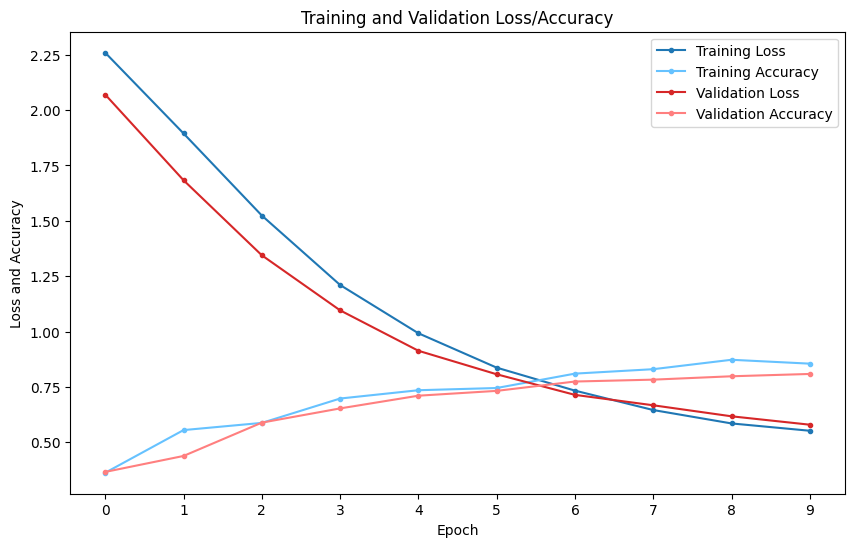


Test Sequence Length: 500
Testing Standard LSTM:
Segment 01/05 | Loss: 0.5848 | Accuracy: 0.8126
Segment 02/05 | Loss: 0.5907 | Accuracy: 0.8068
Segment 03/05 | Loss: 0.5931 | Accuracy: 0.8059
Segment 04/05 | Loss: 0.5838 | Accuracy: 0.8153
Segment 05/05 | Loss: 0.5625 | Accuracy: 0.8195

Final Test Loss: 0.5830 | Final Test Accuracy: 0.8120
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2799 | Val Loss: 2.1186 | Training Accuracy: 0.3050 | Val Accuracy: 0.2922
Epoch 02 | Training Loss: 1.9306 | Val Loss: 1.7267 | Training Accuracy: 0.4550 | Val Accuracy: 0.4333
Epoch 03 | Training Loss: 1.5884 | Val Loss: 1.3935 | Training Accuracy: 0.5150 | Val Accuracy: 0.5451
Epoch 04 | Training Loss: 1.2951 | Val Loss: 1.2037 | Training Accuracy: 0.5850 | Val Accuracy: 0.6099
Epoch 05 | Training Loss: 1.1138 | Val Loss: 1.0500 | Training Accuracy: 0.6325 | Val Accuracy: 0.6540
Epoch 

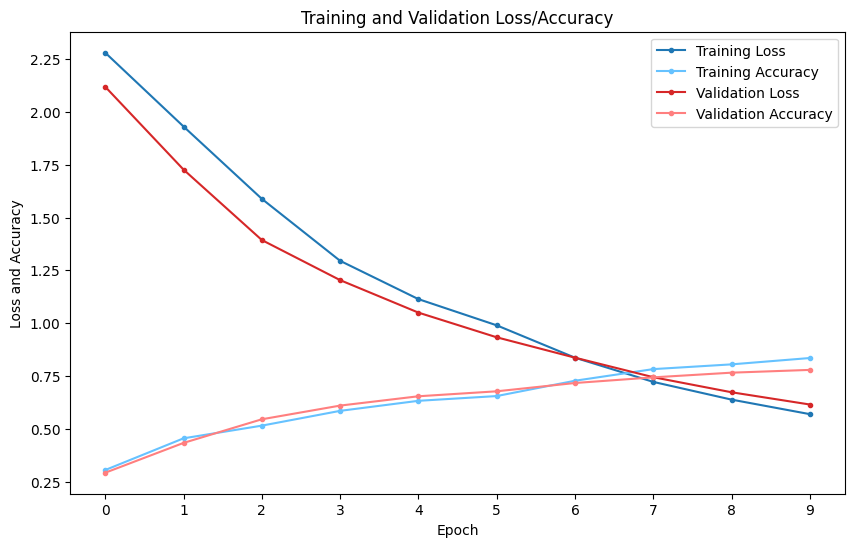


Test Sequence Length: 500
Testing Multiplicative LSTM:
Segment 01/05 | Loss: 0.6367 | Accuracy: 0.7714
Segment 02/05 | Loss: 0.6332 | Accuracy: 0.7723
Segment 03/05 | Loss: 0.6597 | Accuracy: 0.7615
Segment 04/05 | Loss: 0.6491 | Accuracy: 0.7626
Segment 05/05 | Loss: 0.6312 | Accuracy: 0.7739

Final Test Loss: 0.6420 | Final Test Accuracy: 0.7683
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.2811 | Val Loss: 1.9676 | Training Accuracy: 0.2725 | Val Accuracy: 0.4370
Epoch 02 | Training Loss: 1.8142 | Val Loss: 1.5439 | Training Accuracy: 0.4825 | Val Accuracy: 0.5626
Epoch 03 | Training Loss: 1.4107 | Val Loss: 1.2004 | Training Accuracy: 0.6275 | Val Accuracy: 0.6417
Epoch 04 | Training Loss: 1.0906 | Val Loss: 0.9523 | Training Accuracy: 0.7225 | Val Accuracy: 0.7162
Epoch 05 | Training Loss: 0.8966 | Val Loss: 0.7999 | Training Accuracy: 0.7075 | Val Accuracy: 0.8017
Epoch 0

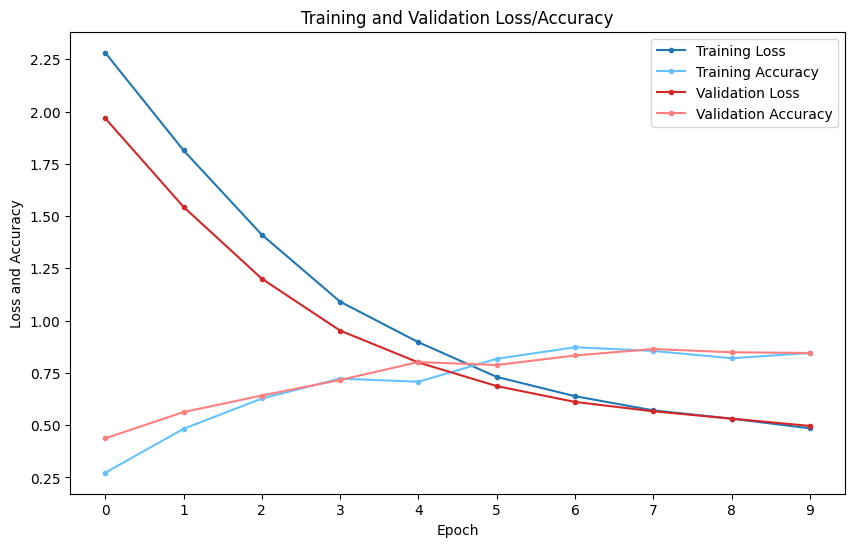


Test Sequence Length: 500
Testing Standard GRU:
Segment 01/05 | Loss: 0.5134 | Accuracy: 0.8387
Segment 02/05 | Loss: 0.5177 | Accuracy: 0.8325
Segment 03/05 | Loss: 0.5233 | Accuracy: 0.8324
Segment 04/05 | Loss: 0.5230 | Accuracy: 0.8333
Segment 05/05 | Loss: 0.5104 | Accuracy: 0.8327

Final Test Loss: 0.5175 | Final Test Accuracy: 0.8339
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.3632 | Val Loss: 2.1177 | Training Accuracy: 0.2000 | Val Accuracy: 0.2953
Epoch 02 | Training Loss: 2.0033 | Val Loss: 1.8268 | Training Accuracy: 0.3400 | Val Accuracy: 0.3583
Epoch 03 | Training Loss: 1.7494 | Val Loss: 1.6074 | Training Accuracy: 0.4275 | Val Accuracy: 0.4284
Epoch 04 | Training Loss: 1.5073 | Val Loss: 1.4104 | Training Accuracy: 0.5125 | Val Accuracy: 0.5209
Epoch 05 | Training Loss: 1.3228 | Val Loss: 1.2448 | Training Accuracy: 0.5825 | Val Accuracy: 0.5648
Epoch 06

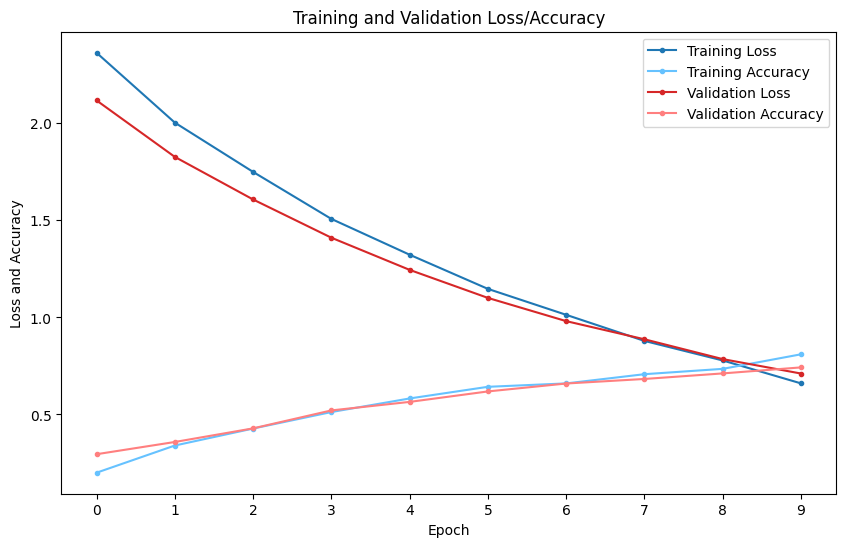


Test Sequence Length: 500
Testing Multiplicative GRU:
Segment 01/05 | Loss: 0.7259 | Accuracy: 0.7407
Segment 02/05 | Loss: 0.7343 | Accuracy: 0.7339
Segment 03/05 | Loss: 0.7330 | Accuracy: 0.7351
Segment 04/05 | Loss: 0.7431 | Accuracy: 0.7321
Segment 05/05 | Loss: 0.7153 | Accuracy: 0.7436

Final Test Loss: 0.7303 | Final Test Accuracy: 0.7371
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 3/3 on sequence length of 500 ***
Standard LSTM
Final Test Loss: 0.5830
Final Test Accuracy: 0.8120

Multiplicative LSTM
Final Test Loss: 0.6420
Final Test Accuracy: 0.7683

Standard GRU
Final Test Loss: 0.5175
Final Test Accuracy: 0.8339

Multiplicative GRU
Final Test Loss: 0.7303
Final Test Accuracy: 0.7371

Training Standard LSTM:
Epoch 01 | Training Loss: 2.2354 | Val Loss: 2.0568 | Training Accuracy: 0.3100 | Val Accuracy: 0.2615
Epoch 02 | Training Loss: 1.8888 | Val Loss: 1.6978 | Training Accuracy:

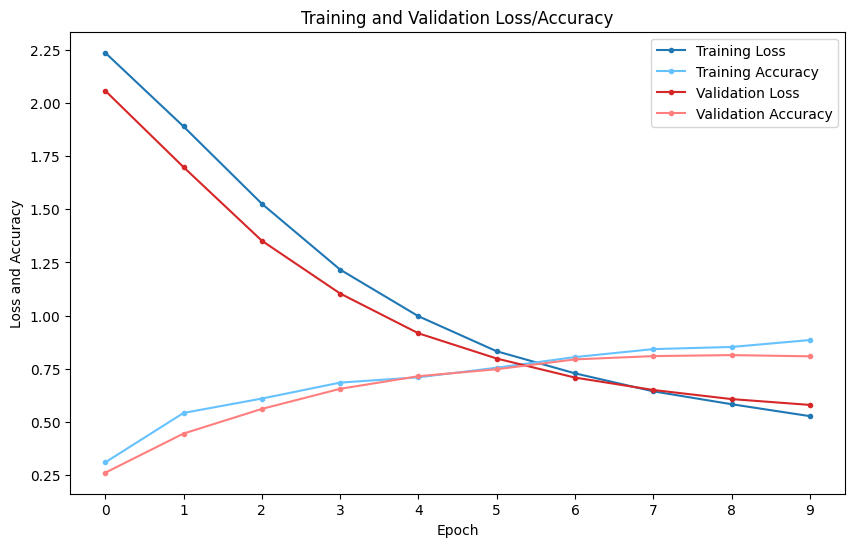


Test Sequence Length: 1000
Testing Standard LSTM:
Segment 01/10 | Loss: 0.5927 | Accuracy: 0.7980
Segment 02/10 | Loss: 0.5828 | Accuracy: 0.8097
Segment 03/10 | Loss: 0.5758 | Accuracy: 0.8128
Segment 04/10 | Loss: 0.5891 | Accuracy: 0.8062
Segment 05/10 | Loss: 0.5857 | Accuracy: 0.8064
Segment 06/10 | Loss: 0.5853 | Accuracy: 0.8072
Segment 07/10 | Loss: 0.5721 | Accuracy: 0.8177
Segment 08/10 | Loss: 0.5941 | Accuracy: 0.8053
Segment 09/10 | Loss: 0.5777 | Accuracy: 0.8140
Segment 10/10 | Loss: 0.5640 | Accuracy: 0.8167

Final Test Loss: 0.5819 | Final Test Accuracy: 0.8094
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2769 | Val Loss: 2.0716 | Training Accuracy: 0.2475 | Val Accuracy: 0.3112
Epoch 02 | Training Loss: 1.8948 | Val Loss: 1.6784 | Training Accuracy: 0.4350 | Val Accuracy: 0.4375
Epoch 03 | Training Loss: 1.5143 | Val Loss: 1.3910 | Training Accuracy: 0

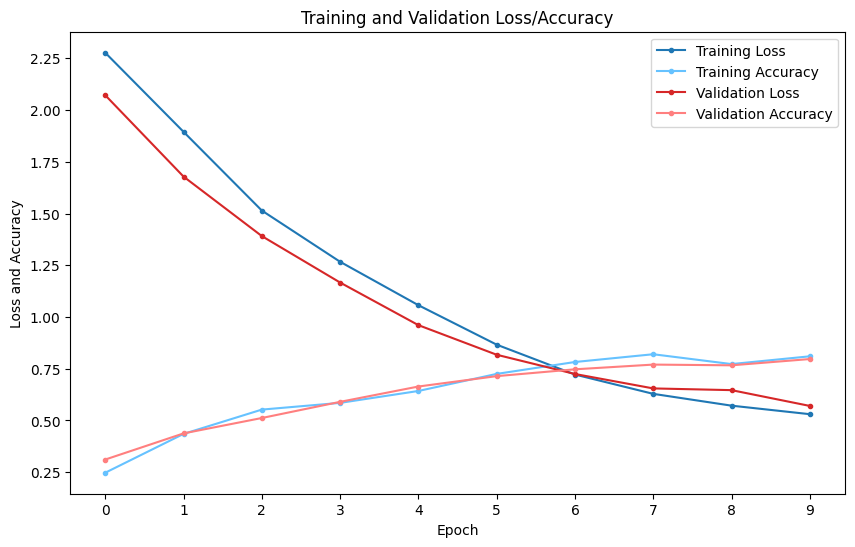


Test Sequence Length: 1000
Testing Multiplicative LSTM:
Segment 01/10 | Loss: 0.5712 | Accuracy: 0.7930
Segment 02/10 | Loss: 0.5766 | Accuracy: 0.7899
Segment 03/10 | Loss: 0.5723 | Accuracy: 0.7965
Segment 04/10 | Loss: 0.5702 | Accuracy: 0.7964
Segment 05/10 | Loss: 0.5690 | Accuracy: 0.7986
Segment 06/10 | Loss: 0.5670 | Accuracy: 0.7972
Segment 07/10 | Loss: 0.5805 | Accuracy: 0.7911
Segment 08/10 | Loss: 0.5646 | Accuracy: 0.7951
Segment 09/10 | Loss: 0.5740 | Accuracy: 0.7928
Segment 10/10 | Loss: 0.5571 | Accuracy: 0.7937

Final Test Loss: 0.5702 | Final Test Accuracy: 0.7944
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.2738 | Val Loss: 2.0080 | Training Accuracy: 0.3175 | Val Accuracy: 0.2567
Epoch 02 | Training Loss: 1.8051 | Val Loss: 1.5389 | Training Accuracy: 0.5925 | Val Accuracy: 0.5456
Epoch 03 | Training Loss: 1.3823 | Val Loss: 1.1824 | Training Accuracy: 0.

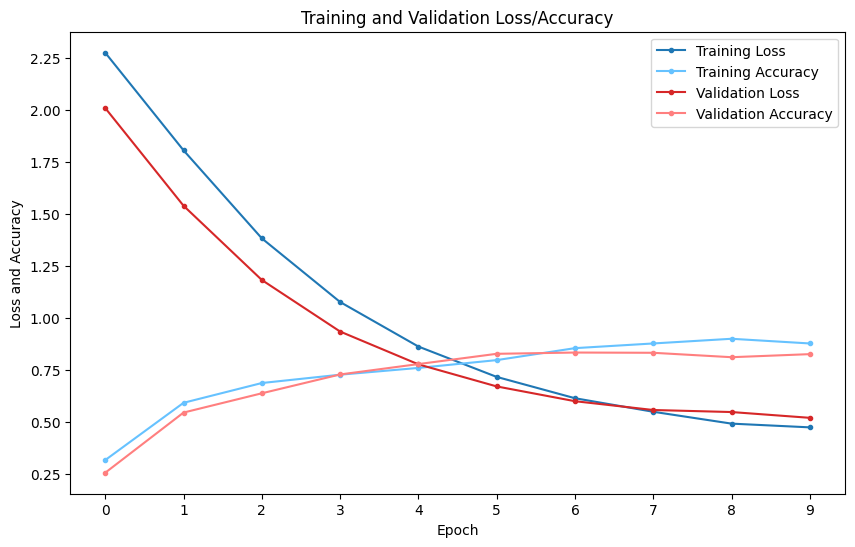


Test Sequence Length: 1000
Testing Standard GRU:
Segment 01/10 | Loss: 0.5323 | Accuracy: 0.8226
Segment 02/10 | Loss: 0.5386 | Accuracy: 0.8191
Segment 03/10 | Loss: 0.5369 | Accuracy: 0.8165
Segment 04/10 | Loss: 0.5412 | Accuracy: 0.8164
Segment 05/10 | Loss: 0.5426 | Accuracy: 0.8175
Segment 06/10 | Loss: 0.5368 | Accuracy: 0.8178
Segment 07/10 | Loss: 0.5460 | Accuracy: 0.8138
Segment 08/10 | Loss: 0.5365 | Accuracy: 0.8202
Segment 09/10 | Loss: 0.5442 | Accuracy: 0.8100
Segment 10/10 | Loss: 0.5279 | Accuracy: 0.8169

Final Test Loss: 0.5383 | Final Test Accuracy: 0.8171
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.2757 | Val Loss: 2.0400 | Training Accuracy: 0.2925 | Val Accuracy: 0.2848
Epoch 02 | Training Loss: 1.9447 | Val Loss: 1.7496 | Training Accuracy: 0.3400 | Val Accuracy: 0.4156
Epoch 03 | Training Loss: 1.6241 | Val Loss: 1.5022 | Training Accuracy: 0.4

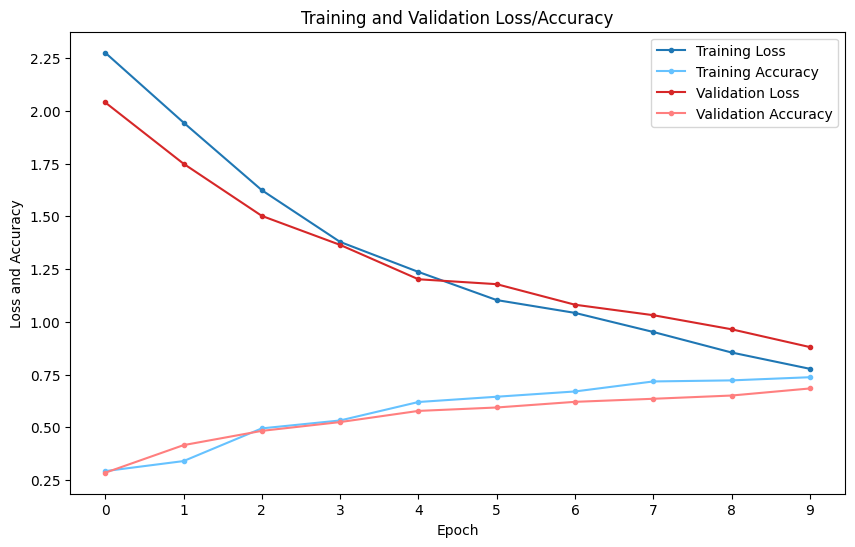


Test Sequence Length: 1000
Testing Multiplicative GRU:
Segment 01/10 | Loss: 0.9121 | Accuracy: 0.6709
Segment 02/10 | Loss: 0.9026 | Accuracy: 0.6735
Segment 03/10 | Loss: 0.8980 | Accuracy: 0.6804
Segment 04/10 | Loss: 0.8973 | Accuracy: 0.6712
Segment 05/10 | Loss: 0.8842 | Accuracy: 0.6743
Segment 06/10 | Loss: 0.9080 | Accuracy: 0.6716
Segment 07/10 | Loss: 0.8924 | Accuracy: 0.6779
Segment 08/10 | Loss: 0.8875 | Accuracy: 0.6766
Segment 09/10 | Loss: 0.9132 | Accuracy: 0.6699
Segment 10/10 | Loss: 0.8643 | Accuracy: 0.6918

Final Test Loss: 0.8960 | Final Test Accuracy: 0.6758
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 3/3 on sequence length of 1000 ***
Standard LSTM
Final Test Loss: 0.5819
Final Test Accuracy: 0.8094

Multiplicative LSTM
Final Test Loss: 0.5702
Final Test Accuracy: 0.7944

Standard GRU
Final Test Loss: 0.5383
Final Test Accuracy: 0.8171

Multiplicative GRU
Final Test

In [20]:
run_copytask_benchmark()

# 4. Analyzing Copy Task Results

### Analysis of Results

As can be seen in the final metric report table outputted above, the key metrics that are analyzed are mean accuracy, standard error of accuracy, mean loss, and standard error of loss.

These results show that the models performed fairly well overall, being able to achieve accuracies of 70% to 80% correct. This means that the models are able to somewhat succesfully "copy" the sequence after training. The loss also steadily decreases for both the train and validation set, meaning that the model is not necessarily overfitting or memorizing the sequence and that the models are stable (vanishing and exploding gradients aren't present based on the plotted graphs).

### Which Model Handles Best?

The model that best handled the largest tested sequence (sequence length `k = 1000`) was the Standard GRU model. This is because it had the highest accuracy of 0.8279 when compared to the other models longest sequences. It also had relatively low standard error (second lowest of the four models), indicating that there is little variation between the accuracies calculated.

Overall, I was expecting the multiplicative GRU or LSTM to perform better than the standard models for longer sequences, however that turned out to not be the case as I mentioned above. I believe this all boils down to how much I trained the model and the additional complexity that is introduced with multiplicative LSTM/GRU (the additional memory vector/matrix). I was also surprised to see that the standard LSTM/GRU tended to converge a bit faster than the multiplicative variations of the model.

My guess to improve performance and loss of the multiplicative LSTM and GRU models would be to perform additional hyper-parameter optimization (maybe through grid-search like the previous assignment). However, this could take a lot more time to compute and run through the different variations.

### Observed Gradient Flow and Convergence between Multiplicative Models

As I was talking about previously, I was surprised to see that the multiplicative LSTM and GRU models did not reach faster convergence when compared to the standard variations, since their accuracies tended to be lower and loss tended to be greater (particularly with larger sequences).

Therefore, despite my assumptions, the data shows that long-term gradient flow was not actually easier in the multiplicative models.

### Observations on Multiplicative Effects

In regards to the gating mechanisms used, the Multiplicative LSTM and Multiplicative GRU introduce an additional memory vector `m`. Technically, this modifies the input to allow for more complex/longer dependencies to be held, since the standard models rely soley on input, hidden state, and bias terms to regulate their gating.

In the end, Standard GRU was able to outperform the other models, even the multiplicative variations. This might have also been due to the specific task being carried out (the copy task), and which other tasks like language modeling, it might perform worse since having greater context with language usually always is better in predicting or translating (which is why multiplicative would be preferred).

### Potential Drawbacks

The main drawback I believe is either sequence lengths being too short or the hyper-parameters not being the most optimized. I feel that adjusting the hyper-parameters could lead to better results.

In the section below this analysis, I also will run through a much longer sequence to really prove if standard GRU can outperform the multiplicative variations of the models tested as it did in the above trials. If this is the case, then the drawback is definitely related to the hyper-parameters, where adjusting the number of epochs, learning rate, and batch size could improve performance results.

### Conclusion

All in all, the results show that the models generally performed well, achieving high accuracies (but not perfect), with steadily decreasing loss and increasing accuracy. The standard GRU and LSTM models did perform better than the multiplicative variations, likely due to the added complexity of the multiplicative models and not fully optimized hyper-parameters. The standard GRU model ended up performing the best overall despite inital assumptions.